# Classification trials

In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [2]:
import os
from io import StringIO
from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import sklearn.metrics as mr
from azure.storage.blob import BlobServiceClient
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    GridSearchCV,
    RepeatedKFold,
    ShuffleSplit,
    StratifiedKFold,
    train_test_split,
)
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
)

In [3]:
%aimport src.altair_helpers
from src.altair_helpers import (
    plot_altair_grid,
    alt_plot_metric_based_threshold_tuning_plots,
)

%aimport src.business_helpers
from src.business_helpers import int_income_calculator

%aimport src.custom_learning_curve_helpers
from src.custom_learning_curve_helpers import learning_curve, manual_learning_curve

%aimport src.custom_looc_importance_helpers
from src.custom_looc_importance_helpers import manual_plot_looc_importance

%aimport src.ml_helpers_v2
from src.ml_helpers_v2 import create_pipe

%aimport src.custom_permutation_importance_helpers
from src.custom_permutation_importance_helpers import manual_plot_permutation_importance

%aimport src.custom_threshold_tuning_plotting_helpers
from src.custom_threshold_tuning_plotting_helpers import (
    # plot_cost_function_based_threshold_tuning_plots,
    plot_metric_based_threshold_tuning_plots,
)

%aimport src.custom_transformers
import src.custom_transformers as ct

%aimport src.ml_helpers_v2
from src.ml_helpers_v2 import get_best_pipes, gridsearch

%aimport src.ml_metrics_v2
from src.ml_metrics_v2 import (
    threshold_roc_auc_score,
    threshold_fpr_score,
    threshold_f2_score,
    threshold_recall_score,
    pr_auc_score,
    get_scores,
    get_eval_metrics,
)

%aimport src.preprocessing_helpers
from src.preprocessing_helpers import get_transformed_data

%aimport src.threshold_tuning_helpers
from src.threshold_tuning_helpers import compute_cost_for_thresholds

%aimport src.visualization_helpers
from src.visualization_helpers import (
    plot_learning_curve,
    builtin_plot_permutation_importances,
    plot_boxplot_using_quantiles,
    plot_grouped_bar_chart,
    plot_grouped_histogram,
    plot_lower_corr_heatmap,
    plot_pr_roc_curves,
    plot_single_column_histogram,
)

In [4]:
# load JS visualization code to notebook
shap.initjs()

In [5]:
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_colwidth", 500)
pd.set_option("display.width", 1000)

## About

This notebook will walk through machine learning classification experiments on the raw [Lending Club loans data](https://www.lendingclub.com/auth/login?login_url=%2Fstatistics%2Fadditional-statistics%3F). A best-performing model will then be determined and assessed in the context of the business use case for this project.i.e. an conservative investor wanting to use the model developed here to predict which loan applications on the [Lending Club platform](https://www.lendingclub.com/), will not [default](https://en.wikipedia.org/wiki/Default_(finance)), and therefore are candidates to be funded.

## User Inputs

User inputs and helper functions, to be used later, are defined below

In [6]:
PROJ_ROOT_DIR = os.path.abspath(os.getcwd())
data_dir = os.path.join(PROJ_ROOT_DIR, "data")

In [7]:
raw_data_file_path = os.path.join(data_dir, "raw", "lending_club_loans.csv")
cloud_storage = "no"

# From Feature Reduction
nan_threshold = 0.5
non_useful_cols = ["url", "desc"]
datetime_cols = ["issue_d", "last_pymnt_d"]
cols_one_eighteen = [
    "id",
    "member_id",
    "funded_amnt",
    "funded_amnt_inv",
    "grade",
    "sub_grade",
    "emp_title",
]
cols_eighteen_thirtysix = [
    "zip_code",
    "out_prncp",
    "out_prncp_inv",
    "total_pymnt",
    "total_pymnt_inv",
    "total_rec_prncp",
]
cols_thirtyseven_end = [
    "total_rec_int",
    "total_rec_late_fee",
    "recoveries",
    "collection_recovery_fee",
    "last_pymnt_amnt",
]
loan_status = ["Fully Paid", "Charged Off"]
mapping_dictionary_labels = {"loan_status": {"Fully Paid": 1, "Charged Off": 0}}
four_or_less_value_columns = ["pymnt_plan"]

# From Feature Processing
more_than_one_pct_missing_columns = ["pub_rec_bankruptcies"]
datetime_cols_v2 = ["last_credit_pull_d", "earliest_cr_line"]
high_cardinality_cols = ["addr_state"]
mapping_dict_emp_length = {
    "emp_length": {
        "10+ years": 10,
        "9 years": 9,
        "8 years": 8,
        "7 years": 7,
        "6 years": 6,
        "5 years": 5,
        "4 years": 4,
        "3 years": 3,
        "2 years": 2,
        "1 year": 1,
        "< 1 year": 0,
        "n/a": 0,
    }
}
nominal_columns = ["home_ownership", "verification_status", "purpose", "term"]
repeated_data_cols = ["title"]
pct_to_numeric_cols = ["int_rate", "revol_util"]

# From Exploratory Data Analysis 1/2
correlated_features = [
    "total_acc",
    "installment",
    "fico_range_low",
    "fico_range_high",
]
look_ahead_features = ["last_fico_range_low", "last_fico_range_high"]
raw_labels = ["loan_status"]
new_labels = ["is_default"]

# Custom Preferences
cols_to_show = [
    "preprocessor_type",
    "resamplers",
    "threshold",
    "params",
    "mean_test_recall_binary",
    "mean_test_fpr",
    "mean_test_auc",
    "mean_train_recall_binary",
    "mean_train_fpr",
    "mean_train_auc",
    "mean_fit_time",
    "std_train_recall_binary",
    "std_test_recall_binary",
    "std_train_fpr",
    "std_test_fpr",
    "mean_score_time",
    "clf_params",
]

# Discrimination Thresholds
thresholds_list = [0.01, 1, 0.01]

# Learning curve - number of training split sizes to use
learning_curve_train_size_blocks = 5

In [8]:
thresholds_list = np.arange(thresholds_list[0], thresholds_list[1], thresholds_list[2])
nan_threshold = float(nan_threshold)
for k in ["Fully Paid", "Charged Off"]:
    mapping_dictionary_labels["loan_status"][k] = int(
        mapping_dictionary_labels["loan_status"][k]
    )
for k in [
    "10+ years",
    "9 years",
    "8 years",
    "7 years",
    "6 years",
    "5 years",
    "4 years",
    "3 years",
    "2 years",
    "1 year",
    "< 1 year",
    "n/a",
]:
    mapping_dict_emp_length["emp_length"][k] = int(
        mapping_dict_emp_length["emp_length"][k]
    )

# From Exploratory Data Analysis 2/2
mapping_dict_new_labels = {"is_default": {0: 1, 1: 0}}

In [9]:
multi_scorers = {
    "recall_binary": mr.make_scorer(
        threshold_recall_score,
        greater_is_better=True,
        needs_proba=True,
        threshold=0.5,
    ),
    "fpr": mr.make_scorer(
        threshold_fpr_score,
        greater_is_better=False,
        needs_proba=True,
        threshold=0.5,
    ),
    "f2": mr.make_scorer(
        threshold_f2_score,
        greater_is_better=True,
        needs_proba=True,
        threshold=0.5,
    ),
    "roc_auc_binary": mr.make_scorer(
        threshold_roc_auc_score,
        greater_is_better=True,
        needs_proba=True,
        threshold=0.5,
    ),
    "pr_auc": mr.make_scorer(
        pr_auc_score,
        greater_is_better=True,
        needs_proba=True,
    ),
}
cols_to_show = [
    "mean_test_recall_binary",
    "mean_test_fpr",
    "mean_test_roc_auc_binary",
    "mean_test_pr_auc",
    "mean_train_recall_binary",
    "mean_train_fpr",
    "mean_train_roc_auc_binary",
    "mean_train_pr_auc",
    "mean_fit_time",
    "std_train_recall_binary",
    "std_test_recall_binary",
    "std_train_fpr",
    "std_test_fpr",
    "std_train_roc_auc_binary",
    "std_test_roc_auc_binary",
    "std_train_pr_auc",
    "std_test_pr_auc",
    "mean_score_time",
]

## Load data

Raw data from Lending Club is loaded into memory

In [10]:
if cloud_storage == "yes":
    az_storage_container_name = "myconedesx7"
    conn_str = (
        "DefaultEndpointsProtocol=https;"
        f"AccountName={os.getenv('AZURE_STORAGE_ACCOUNT')};"
        f"AccountKey={os.getenv('AZURE_STORAGE_KEY')};"
        f"EndpointSuffix={os.getenv('ENDPOINT_SUFFIX')}"
    )
    blob_service_client = BlobServiceClient.from_connection_string(conn_str=conn_str)

    blobstrings = {}
    for blob_name in ["blobedesz38"]:
        blob_client = blob_service_client.get_blob_client(
            container=az_storage_container_name, blob=blob_name
        )
        blobstring = blob_client.download_blob().content_as_text()
    df = pd.read_csv(StringIO(blobstring), skiprows=1, low_memory=False)
else:
    df = pd.read_csv(raw_data_file_path, skiprows=0, low_memory=False)

## Train-Test split

A hold-out set of the raw data will be set aside for model assessment

In [11]:
df_train_val, df_test = train_test_split(df, test_size=0.33, random_state=4321)
df_train, df_val = train_test_split(df_train_val, test_size=0.33, random_state=4321)

## Data processing

The raw data is cleaned, filtered and features are extracted/selected from this processed data in order to run experiments in classification

In [ ]:
# !pygmentize src/custom_transformers.py

In [12]:
pipe_1_2_3 = Pipeline(
    [
        # nan_threshold=0.5, is a float in [0, 1.0] - CAN CHANGE OR KEEP UNCHANGED
        ("nanthresh", ct.DFNanThresholdColumnDropper(0.5)),
        ("nouse", ct.DFColumnDropper(non_useful_cols)),
        ("dtime", ct.DFColumnDropper(datetime_cols)),
        ("c1", ct.DFColumnDropper(cols_one_eighteen)),
        ("c2", ct.DFColumnDropper(cols_eighteen_thirtysix)),
        ("c3", ct.DFColumnDropper(cols_thirtyseven_end)),
        (
            "mapstatus",
            ct.DFColumnFilterList("loan_status", loan_status),
        ),
        ("colmap", ct.DFColumnMapper(mapping_dictionary_labels)),
        ("onevals", ct.DFNonUniqueValColDropper(num_non_unique_vals=1)),
        # four_or_less_value_columns=['pymnt_plan'] - 'pymnt_plan' is MOSTLY 'n', EXCLUDE
        ("fourvals", ct.DFColumnDropper(four_or_less_value_columns)),
        # more_than_one_pct_missing_columns = ['pub_rec_bankruptcies']
        ("morethan1pctnan", ct.DFColumnDropper(more_than_one_pct_missing_columns)),
        ("nan", ct.DFDropNaN()),
        # high_cardinality_cols=['addr_state'] - CAN INCLUDE OR EXCLUDE
        ("hcardcols", ct.DFColumnDropper(high_cardinality_cols)),
        ("dtimev2", ct.DFColumnDropper(datetime_cols_v2)),
        ("texttonum", ct.DFColumnMapper(mapping_dict_emp_length)),
        ("repeats", ct.DFColumnDropper(repeated_data_cols)),
        ("pctcols", ct.DFPctNumeric(pct_to_numeric_cols, "%")),
        (
            "singlecolmap",
            ct.DFSingleColumnMapper("loan_status", mapping_dict_new_labels),
        ),
        ("dtype", ct.DFSimpleDtypeChanger(new_labels, "int")),
        # n_std is an integer - CAN CHANGE OR KEEP UNCHANGED
        ("stdfilter", ct.DFColumnStdFilter("annual_inc", 3)),
        # correlated_features=['total_acc','installment','fico_range_low','fico_range_high'] EXCLUDE
        ("corr", ct.DFColumnDropper(correlated_features)),
        ("lookahead", ct.DFColumnDropper(look_ahead_features)),
        ("label", ct.DFColumnDropper(raw_labels)),
        # requires ("corr", ...) to be removed; threshold=1, ideally chosen from dendogram
        # ("clusterselect", ct.DFHierarchicalClusterSpearmanRank(threshold=1)),
    ]
)
df_pipe_transformed_train = pipe_1_2_3.fit_transform(df_train)
df_pipe_transformed_val = pipe_1_2_3.transform(df_val)
df_pipe_transformed_train_val = pipe_1_2_3.transform(df_train_val)
df_pipe_transformed_test = pipe_1_2_3.transform(df_test)
print(df_pipe_transformed_train.shape)
print(df_pipe_transformed_val.shape)
print(df_pipe_transformed_train_val.shape)
print(df_pipe_transformed_test.shape)
display(df_pipe_transformed_train.head(2))
display(df_pipe_transformed_val.head(2))
display(df_pipe_transformed_train_val.head(2))
display(df_pipe_transformed_test.head(2))
display(df_pipe_transformed_train["is_default"].squeeze().value_counts(dropna=False))

(16998, 16)
(8347, 16)
(25361, 16)
(12469, 16)


,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,is_default
36400,4800.0,36 months,11.89,10,RENT,41300.0,Not Verified,debt_consolidation,18.65,0.0,1.0,5.0,1.0,4224.0,40.2,0
20156,12000.0,60 months,14.91,1,MORTGAGE,36000.0,Source Verified,major_purchase,13.43,0.0,3.0,8.0,1.0,5049.0,78.9,0


,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,is_default
22692,1800.0,36 months,12.61,0,MORTGAGE,36000.0,Source Verified,other,6.30,0.0,1.0,14.0,0.0,5903.0,36.9,0
13071,6000.0,36 months,6.99,9,RENT,65000.0,Verified,debt_consolidation,28.45,0.0,0.0,7.0,0.0,13041.0,42.9,0


,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,is_default
39296,15250.0,36 months,11.34,10,MORTGAGE,75000.0,Not Verified,debt_consolidation,15.14,0.0,0.0,11.0,0.0,39702.0,84.5,0
2652,6000.0,36 months,15.96,4,RENT,72000.0,Not Verified,credit_card,4.15,0.0,2.0,7.0,0.0,7600.0,82.6,0


,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,is_default
9990,8450.0,60 months,11.49,1,RENT,42000.0,Source Verified,debt_consolidation,24.71,0.0,0.0,12.0,0.0,8252.0,23.8,1
27119,13000.0,60 months,15.58,4,RENT,109896.0,Source Verified,wedding,12.28,0.0,0.0,11.0,0.0,13.0,0.2,1


0    14547
1     2451
Name: is_default, dtype: int64

## Get features and class labels from processed data

The features and labels are now extracted from the processed training and testing splits

In [13]:
X_train = df_pipe_transformed_train.drop(labels=new_labels, axis=1)
y_train = df_pipe_transformed_train[new_labels].astype(int).squeeze()
X_val = df_pipe_transformed_val.drop(labels=new_labels, axis=1)
y_val = df_pipe_transformed_val[new_labels].astype(int).squeeze()
X_train_val = df_pipe_transformed_train_val.drop(labels=new_labels, axis=1)
y_train_val = df_pipe_transformed_train_val[new_labels].astype(int).squeeze()
X_test = df_pipe_transformed_test.drop(labels=new_labels, axis=1)
y_test = df_pipe_transformed_test[new_labels].astype(int).squeeze()
display(X_train.head(2))
display(X_val.head(2))
display(X_test.head(2))
display(X_train_val.head(2))
display(y_train.to_frame().head(2))
display(y_val.to_frame().head(2))
display(y_test.to_frame().head(2))
display(y_train_val.to_frame().head(2))

,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util
36400,4800.0,36 months,11.89,10,RENT,41300.0,Not Verified,debt_consolidation,18.65,0.0,1.0,5.0,1.0,4224.0,40.2
20156,12000.0,60 months,14.91,1,MORTGAGE,36000.0,Source Verified,major_purchase,13.43,0.0,3.0,8.0,1.0,5049.0,78.9


,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util
22692,1800.0,36 months,12.61,0,MORTGAGE,36000.0,Source Verified,other,6.30,0.0,1.0,14.0,0.0,5903.0,36.9
13071,6000.0,36 months,6.99,9,RENT,65000.0,Verified,debt_consolidation,28.45,0.0,0.0,7.0,0.0,13041.0,42.9


,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util
9990,8450.0,60 months,11.49,1,RENT,42000.0,Source Verified,debt_consolidation,24.71,0.0,0.0,12.0,0.0,8252.0,23.8
27119,13000.0,60 months,15.58,4,RENT,109896.0,Source Verified,wedding,12.28,0.0,0.0,11.0,0.0,13.0,0.2


,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util
39296,15250.0,36 months,11.34,10,MORTGAGE,75000.0,Not Verified,debt_consolidation,15.14,0.0,0.0,11.0,0.0,39702.0,84.5
2652,6000.0,36 months,15.96,4,RENT,72000.0,Not Verified,credit_card,4.15,0.0,2.0,7.0,0.0,7600.0,82.6


,is_default
36400,0
20156,0


,is_default
22692,0
13071,0


,is_default
9990,1
27119,1


,is_default
39296,0
2652,0


## Assemble components for `GridSearchCV`

The pipeline inputs and other components required for hyperparameter optimization using `GridSearchCV` are extracted here

### Lists of features by type

A list of numerical and categorical features is extracted from the processed data
- numerical features are those with a datatype of `float`
- categorical features are those that do not have a datatype of `float`

In [14]:
numerical_columns = [
    c
    for c in list(X_train.select_dtypes(exclude="object"))
    if c not in new_labels + ["emp_length"]
]
nominal_columns = list(X_train.select_dtypes(include="object")) + ["emp_length"]
try:
    assert set(numerical_columns + nominal_columns) == set(list(X_train)) - set(
        new_labels
    )
    print("Columns from training data match feature lists based on datatypes")
except AssertionError as e:
    print(
        "Some columns from training data are missing from feature lists based on datatypes"
    )
print("Categoricals:\n-" + "\n-".join(nominal_columns))
print("Numericals:\n-" + "\n-".join(numerical_columns))

Columns from training data match feature lists based on datatypes
Categoricals:
-term
-home_ownership
-verification_status
-purpose
-emp_length
Numericals:
-loan_amnt
-int_rate
-annual_inc
-dti
-delinq_2yrs
-inq_last_6mths
-open_acc
-pub_rec
-revol_bal
-revol_util


### Feature transformations

Below, feature transformations to be applied to all numerical and [categorical](https://en.wikipedia.org/wiki/Categorical_variable) columns are defined. With or without transformations, all numerical features will be normalized. All categorical features will be one-hot encoded.

In [15]:
col_transformers = {
    c: Pipeline(
        steps=[
            ("trans", ct.DFPowerTransformer("yeo-johnson")),
            ("ss", ct.DFStandardScaler()),
        ]
    )
    for c in numerical_columns
}
preprocessors = {
    "no_trans": ColumnTransformer(
        transformers=[
            (
                "nums",
                Pipeline(steps=[("trans", StandardScaler())]),
                numerical_columns,
            )
        ]
        + [("onehot", ct.DFOneHotEncoderV2(handle_unknown="ignore"), nominal_columns)],
        remainder="passthrough",
    ),
    "trans": ColumnTransformer(
        transformers=[(k, v, [k]) for k, v in col_transformers.items()]
        + [("onehot", ct.DFOneHotEncoderV2(handle_unknown="ignore"), nominal_columns)],
        remainder="passthrough",
    ),
}
feat_selector = ct.DFCorrColumnDropper(0.5, "spearman")

### ML Classification Models and Hyper-Parameters for Optimization

The models to be compared and dictionaries of model hyper-parameters for tuning, are defined below
- for hyper-parameter dictionaries containing cost-function weights, for manual specification of the penalties used in the algorithm's cost function, the larger penalty should be assigned to the minority class (see [**Lesson 07. Cost-Sensitive Algorithms**](https://machinelearningmastery.com/imbalanced-classification-with-python-7-day-mini-course/))
  - here, this is for the positive class where `is_default`==1, and is explicitly shown below through the class-balance of the labels from the training data

In [16]:
y_train.value_counts().to_frame()

,is_default
0,14547
1,2451


In [17]:
vc = np.unique(y_train, return_counts=True)[1]
minority_weight = vc[0] / vc[1]
parameters = {
    "LogisticRegression": {
        "C": [1.0],
        "class_weight": [
            "balanced",
            None,
            {0: 1, 1: 1},
            {0: 1, 1: minority_weight},
            {0: 1, 1: 8},
        ],
    },
    "DummyClassifier": {"strategy": ["stratified"]},
}

## ML Model Selection

### Hyper-Parameter GridSearch

A grid search over the custom-defined space of hyperparameters is now performed using the `gridsearch()` helper function

In [ ]:
# !cat -n src/ml_helpers_v2.py | sed -n -e 1,14p -e 126,194p

In [18]:
%%time
cv = StratifiedKFold(n_splits=5, shuffle=False)
df_gs = gridsearch(
    X_train,
    y_train,
    parameters,
    preprocessors["no_trans"],
    feat_selector,
    cv,
    multi_scorers,
    threshold=0.5,
)
param_cols = df_gs.columns[
    df_gs.columns.to_series().str.contains("param_")
].tolist()
display(df_gs[["clf"]+param_cols+cols_to_show])

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  25 | elapsed:    4.0s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    4.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


,clf,param_clf__C,param_clf__class_weight,param_clf__strategy,mean_test_recall_binary,mean_test_fpr,mean_test_roc_auc_binary,mean_test_pr_auc,mean_train_recall_binary,mean_train_fpr,mean_train_roc_auc_binary,mean_train_pr_auc,mean_fit_time,std_train_recall_binary,std_test_recall_binary,std_train_fpr,std_test_fpr,std_train_roc_auc_binary,std_test_roc_auc_binary,std_train_pr_auc,std_test_pr_auc,mean_score_time
0,LogisticRegression,1,balanced,NaN,0.627089,0.342271,0.642409,0.287359,0.644838,0.340397,0.652221,0.293751,1.374792,0.005445,0.020331,0.002600,0.009327,0.003404,0.010913,0.002691,0.010822,0.034540
1,LogisticRegression,1,None,NaN,0.022036,0.003918,0.509059,0.287427,0.023562,0.003471,0.510045,0.295787,1.468441,0.001921,0.005979,0.000500,0.001350,0.001076,0.002560,0.002800,0.010626,0.033838
2,LogisticRegression,1,"{0: 1, 1: 1}",NaN,0.022036,0.003918,0.509059,0.287427,0.023562,0.003471,0.510045,0.295787,1.381662,0.001921,0.005979,0.000500,0.001350,0.001076,0.002560,0.002800,0.010626,0.032139
3,LogisticRegression,1,"{0: 1, 1: 5.935128518971848}",NaN,0.627497,0.342477,0.642510,0.287318,0.644838,0.340379,0.652229,0.293741,1.272265,0.005391,0.020213,0.002588,0.009207,0.003417,0.010845,0.002696,0.010834,0.030199
4,LogisticRegression,1,"{0: 1, 1: 8}",NaN,0.764175,0.486287,0.638944,0.287080,0.777336,0.484206,0.646565,0.293396,1.159386,0.000740,0.019294,0.004925,0.007961,0.002692,0.009963,0.002680,0.010867,0.022197
5,DummyClassifier,NaN,NaN,stratified,0.152179,0.142435,0.504872,0.213493,0.154019,0.141180,0.506419,0.215637,0.255816,0.003669,0.011319,0.000614,0.001917,0.002142,0.006618,0.003403,0.010556,0.016876


CPU times: user 1.15 s, sys: 1.76 s, total: 2.91 s
Wall time: 5.42 s


**Observations**
1. The ML models tried perform better than random guessing (`DummyClassifier`) in all metrics except for `FPR`
2. The manually balanced classes approach does not quite agree with the built-in implementation of balanced classes. This is the manual approach assigned penalties using the class balance in the training data. By comparison, the grid search was done using the class balance in each validation fold. These two approaches should not be expected to significantly differ and indeed the two approaches give very similar (though not identical) outputs.

### Extracting the best ML model

New pipelines will be instantiated based on the best-performing ML model- and random guessing-based approaches found from hyper-parameter tuning

In [19]:
best_cfg_idx = 0
best_dummy_cfg_idx = 5
best_pipe, best_dummy_pipe = get_best_pipes(
    best_cfg_idx,
    best_dummy_cfg_idx,
    df_gs,
    preprocessors["no_trans"],
    feat_selector,
    param_cols,
)

### Tuning the Best ML model's Discrimnination Threshold

The training split was used for hyperparameter optimization. It was divided up into training and validation sub-splits as part of cross-validation - each model was trained on the training sub-split and scored on the validation sub-split. With the best hyper-parameters found, the best pipeline will now be trained on the full training split and probabilistic predictions are made on the validation split that has not yet been used. The validation split will be used to tune the discrimination threshold of the best ML model.

In [ ]:
%%time
best_pipe.fit(X_train, y_train)
best_dummy_pipe.fit(X_train, y_train)
y_probs_val = best_pipe.predict_proba(X_val)[:, 1]

#### Tuning threshold using ML scoring metrics

The discrimination threshold is tuned using various ML scoring metrics on the validation split

In [ ]:
# !pygmentize src/custom_threshold_tuning_plotting_helpers.py

In [ ]:
%%time
(
    df_threshold_tuning_scores,
    df_all_threshold_tuning_scores
) = plot_metric_based_threshold_tuning_plots(
    y_val,
    y_probs_val,
    thresholds_list,
    f2_beta=2,
    legend_position=(1.01, 1),
    show_best_t_by_f1=False,
    show_plot=True,
    fig_size=(8, 4),
)
display(df_threshold_tuning_scores)

**Observations**
1. The optimal threshold for
   - `FPR` is at approx. 0.85 or higher
   - `TPR` and `F2` is at approx. 0.2 or lower
   
   Both of these differ from the default threshold of 0.5.
2. Other metrics are also shown on this plot
   - `F1` has an optimal threshold between approx. 0.3-0.45
   - ROC-AUC has its optimal threshold at approx. 0.5

**Considerations**

Depending on the specific use case, it may be necessary tune the threshold to achieve better results using a combination of metrics rather than just one at a time.

In this specific example, where the end user is a conservative investor, is it better (or less costly) to

- Fund a loan to a borrower who defaults
- Withhold funding of a loan to someone who does not default

These are the questions that need to be validated with the stakeholder and taken into account when tuning the discrimination threshold of the model.

#### Methodology for tuning threshold using cost function / loan income

An alternative approach to tune the discrimination threshold involves optimizing the total return (loan income) earned (or lost) by an investor that only follows the predictions of the ML model when deciding whether a loan will result in a default (investor does not fund) or will be paid off on time (investor provides funding).

**Approximate Return on Loan**

The total return (or total loan income) earned on a loan is the sum of monthly payments made by the borrower that are then distributed to the investor. A monthly payment for a loan can be calculated using the formula ([1](https://www.kasasa.com/blog/how-to-calculate-loan-payments-in-3-easy-steps), [2](https://www.vertex42.com/ExcelArticles/amortization-calculation.html), [3](https://www.calculator.net/payment-calculator.html), [4](https://www.thebalance.com/loan-payment-calculations-315564)) below

## $A=P\frac{r(1+r)^n}{(1+r)^n-1}$

The three terms in this formula for monthly payment (`A`) are in the Lending Club dataset
- `int_rate` is the interest rate per year (`r`), expressed as a percentage
  - this will have to be divided by 12 to get the monthly interest rate due on the loan
- `loan_amnt` is the principal (`P`), or value of the loan in dollars (USD)
- `term` is the length of time that a borrower has to repay the loan (`n`), in months and so the number of periodic (monthly) payments that are to be made on the loan
  - for the dataset here, this is 36 or 60 months

Using this formula, the monthly payment (`A`) can be calculated in dollars and it matches the value found in the `installment` column of the data, though that column is not used as an ML feature here.

**Simplifying Assumptions**

This calculation is a simplification for the following reasons
- it is assumed that a default occurs immediately on receipt of the loan and so no monthly payments are ever made by the borrower. This results in loss of the full principal. If some monthly payments were in fact made (without defaulting), then
  - the difference between the principal and the sum of the monthly payments would be the loss incurred by the investor, upon the loan going into default, and not the entire principal
  - penalties in the form of higher interest rates would apply to subsequent payments but  are not accounted for

**Calculating total loan income**

The sum of all the monthly payments (36 or 60 payments, matching the term of the loan) is the total loan income that can be earned on a single loan (A<sub>t</sub>). Note that `A` is the total monthly payment including interest. The interest component of the first monthly payment (`A`) is `r` X `P` and the new principal after the first payment is made would be `P` - `A`. The interest component of the second monthly payment is `r` X (`P` - `A`) and so on.

The total income (sum of all monthly payments) per loan by an investor can be earned by relying on the predictions made by the ML model being developed here. A positive value indicates the investor could receive funds by relying on the ML model, while a negative value indicates that the investor would actually lose money if they relied on the ML model when deciding whether to fund the loan or not.

**Assign penalties (costs) to model's predictions**

Recalling that the positive class here is that a borrower will default and the negative class is that the loan will be paid off on time, there are four types of outcomes that need to be considered when estimating the returns earned by relying on the ML model's predictions and these are discussed below
1. If an ML model predicts a loan will be paid on time and it actually is, then this is the overall return that an investor will theoretically earn by funding the loan. This is the cost of a True Negative (`TN`).
2. If the ML model predicts the loan will result in a default and the loan is actually paid off on time, then this is the prospective loss incurred by the investor by not funding the loan. Since the investor follows the model's recommendation, and does not provide funding, principal is not lost. However, return was there to be earned - and it wasn't! So, the return is lost. This is the cost of a False Positive (`FP`).
3. If the ML model predicts that the loan will be paid off on time and it actually defaults, then the principal is lost. Return was never there to be earned since the loan would have defaulted - it was going to be lost, but the model predicted the opposite. So, the return wasn't lost, but the princpal is. A simplifying assumption is made here: the borrower never made any monthly payments. This is a conservative estimate in the sense that the borrower may make a few of the required monthly payments before defaulting on the loan (when a loan payment is 121 days past due). So, the full principal may not be lost in this case. By assuming the worst case scenario (no payments made), this provides an upper bound on the funds that could be lost by a prospective investor. This is an important factor for a conservative investor - the intentend end user of the ML model being developed here. This is the cost of a False Negative (`FN`).
4. If the ML model predicts that the loan will result in a default and this does happen, then neither principal nor return are lost. There was no return to be made so return was not lost. Since the investor followed the recommendations of the ML model and did not provide funding, no principal was lost either. This is the cost (or lack thereof) of a True Positive (`TP`).

Using these four outcomes, the ML model's predicted return (or total income) on a loan can be estimated using the formula below

## R(t) = -P x FN(t) + (0) x TP(t) + (-A<sub>t</sub>) x FP(t) + (A<sub>t</sub>) x TN(t)

where `FN(t)`, `FP(t)`, `TN(t)` and `TP(t)` are the number of false negatives, false positives, true negatives and true positives respectively and can be extracted from a [confusion matrix](https://classeval.wordpress.com/introduction/basic-evaluation-measures/). Each of these is a function of the discrimination threshold - this means the choice of threshold determines the number of false negatives, true positives, etc. predicted by the model. `R(t)` also depends on the threshold. When applied to the ML model's prediction of a outcome of a single loan, three of `FN`, `FP`, `TN` and `TP` are 0 and the fourth value is 1. `P` is the principal for the loan in question and A<sub>t</sub> is the theoretical return (total of all the monthly payments) that could be earned or lost and was calculated above. Each of `FN`, `FP`, `TN` and `TP` is a function of the discrimination threshold, `t`.

**Estimating error in model's predictions**

The `R(t)` above can be computed for the ML model's predictions of the loan outcome (default or paid on-time)[R<sub>pred</sub>(t)] and for the true outcome [R<sub>true</sub>(t)]. The absolute error (`AE`) is the absolute difference between predicted [R<sub>pred</sub>(t)] and true [R<sub>true</sub>(t)] loan income for a single loan. The optimal value of `t` is one that minimizes the average of the absolute differences between predicted [R<sub>pred</sub>(t)] and true [R<sub>true</sub>(t)] loan incomes over all loans being considered in the data (MAE)

## AE(t) = |R<sub>pred</sub>(t) - R<sub>true</sub>(t)|

## MAE(t) = AE(t) / len(R<sub>pred</sub>)

This optimized discrimination threshold is taken as the best value for the business use case being analyzed here. This optimal `t` will **not** necessarily agree with the choice of `t` that optimizes the ML scoring metrics as shown in the table above (see the `best_threshold` column) - instead, it is a possible alternative to the one that is designed to optimize those ML scoring metrics.

#### Technical details of threshold tuning implementation based on loan income

1. Starting with the best model found from hyper-parameter optimization, extract the columns required to calculate the total of all monthly payments on the loans in the data - these are `int_rate`, `loan_amnt` and `term`. Here, the total of all the monthly payments on a loan (A<sub>t</sub>) is calculated for all loans in the validation split of the data using a helper function `int_income_calculator()` found in `src/business_helpers.py`
   - the helper function `int_rate_calculator()` computes the total return on a single loan and it will be vectorized to perform this computation on all the loans in the validation split. This gives a single column of the total return for each loan.
2. Why the validation split? Since the best model was already determined during hyper-parameter tuning, it will be re-used. As hyper-parameters were tuned on the training split, the trained (best) model will not be re-trained during threshold tuning. Instead, it will be used to generate the class prediction probabilities for all observations in the validation split.
3. A helper function `rowwise_calculate_avg_return_vs_theoretical()` is used to calculate the difference between the ML model's predicted return on a single loan using the formula for `Returns(t)` defined earlier. This functin will use
   - predicted probability (converted to a hard label - 0 or 1) and corresponding true value from the validation split
   - principal, since this is the penalty for a false negative
   - total loan income
     - this is the output of vectorizing the `int_rate_calculator()` helper function

   in order to calculate the predicted and true return for each loan. Using a single predicted (hard) class label and the corresponding true label (`confusion_matrix(y_pred, y_true)`), a confusion matrix similar to

   |          | predicted=0 | predicted=1 |
   |---------:|------------:|------------:|
   | actual=0 |           1 |           0 |
   | actual=1 |           0 |           0 |

   is generated and used to extract the (number of) `FN`, `FP`, `TN` and `TP`. In this table, the ML model predicts the loan is paid off on time and the true outcome is also that the loan is paid off on time. Three of the entries in the confusion matrix will be 0 and the other will be 1 - in the above table, `FP` is 0 and the others are 1. Combining these with the principal (`P`) and total loan income (A<sub>t</sub>), the predicted return can be calculated for the loan. For computing the true return, the predicted class label is represented by the true label (`confusion_matrix(y_true, y_true)`) and the confusion matrix is similarly used.
4. The difference between the predicted and true return is then computed and the average differrence across all loans will be used as the `MAE` scoring metric, as explained above, for tuning the discrimination threshold of the ML model.

In [ ]:
# !pygmentize src/threshold_tuning_helpers.py

Using the above approach, the discrimination threshold is tuned below

In [ ]:
%%time
df_cost_func_tuning = compute_cost_for_thresholds(thresholds_list, X_val, y_val, best_pipe, True, verbose=True)
display(df_cost_func_tuning.head(10))

In [ ]:
alt_plot_metric_based_threshold_tuning_plots(
    pd.concat(
        [
            df_all_threshold_tuning_scores,
            df_cost_func_tuning[df_cost_func_tuning["metric"] == "relative_mae"],
        ]
    ),
    ptitle_offset=-5,
    legend_offset=5,
    figsize=(450, 300),
)

**Observation**
1. The `relative_mae` refers to the MAE normalized relative its maximum value. The lower the `relative_mae` the better.
2. From visual inspection, this occurs a discrimination threshold of approximately 0.8 or higher. This choice supports `FPR`, which should also be as small as possible. However, it strongly opposes `TPR` and `F2`, which should be as high as possible.
3. The best model here could cost the investor as much as approximately $\$$2,000 on average when the optimal threshold is selected based on the return from a loan. This produces an average savings of $\$$1,300 (40%) per loan that the investor would realize by using such an approach to tune the threshold.

The best threshold is now manually selected based on the above graph

In [20]:
# MANUAL THRESHOLD SELECTION REQUIRED, BASED ON ABOVE PLOT
best_t = 0.75

#### Tuned ML model performance compared to random guessing

Here, the loan income that could be lost by following the best ML model, with tuned threshold, is compared to what could be lost by randomly guessing the outcome of a loan - default or paid off on-time

In [ ]:
%%time
dfcts = []
for pipe in [best_dummy_pipe, best_pipe]:
    df_cost_func = compute_cost_for_thresholds([best_t], X_val, y_val, pipe, False, verbose=True).assign(clf=type(pipe.named_steps['clf']).__name__)
    dfcts.append(df_cost_func)
df_cost_funcs = pd.concat(dfcts, ignore_index=True)
df_cost_funcs = df_cost_funcs.pivot(index="metric", columns="clf", values="value")
display(df_cost_funcs)

In [ ]:
bxp_cols = ["label", "whislo", "q1", "med", "q3", "whishi", "fliers"]
boxes = [
    df_cost_funcs.loc[
        bxp_cols, type(best_dummy_pipe.named_steps["clf"]).__name__
    ].to_dict(),
    df_cost_funcs.loc[bxp_cols, type(best_pipe.named_steps["clf"]).__name__].to_dict(),
]
plot_boxplot_using_quantiles(
    boxes, "Val. MAE - Diff. in avg. of abs. return (predicted - true) ($)", 12, (6, 4)
)

**Observations**
1. It is re-assuring that the MAE for the ML model is lower (better) than that from random guessing. However, this difference is only approx. $200, which should be expected given the results of hyper-parameter tuning (high `FNR` and less-than-ideal `TPR`). Further hyper-parameter tuning could possibly improve this, thereby increasing the difference to randomly guessing at the outcome.
2. It is average becuase the model will not alwyas predict that the investor should fund such a loan. There are cases when it incorrectly predicts that the loan should not be funded - in such a scenario, prospective return is lost.

## Model Evaluation

The best ML model with tuned discrumination threshold will now be assessed on data it has not seen before (unseen data).i.e. on the test split

The ML model is first trained on the combined training and validation split

In [21]:
%%time
best_pipe.fit(X_train_val, y_train_val)
best_dummy_pipe.fit(X_train_val, y_train_val)
y_probs_test = best_pipe.predict_proba(X_test)[:, 1]

CPU times: user 1.53 s, sys: 2.37 s, total: 3.9 s
Wall time: 700 ms


### ML Diagnostic metrics and plots

The trained ML model is now scored on the testing split (unseen data) using the tuned discrimination threshold

In [22]:
%%time
dfcts = []
for pipe in [best_dummy_pipe, best_pipe]:
    df_cost_func = compute_cost_for_thresholds([best_t], X_test, y_test, pipe, False, verbose=True).assign(clf=type(pipe.named_steps['clf']).__name__)
    dfcts.append(df_cost_func)
df_cost_funcs = pd.concat(dfcts, ignore_index=True)
df_cost_funcs = df_cost_funcs.pivot(index="metric", columns="clf", values="value")
display(df_cost_funcs)

Model=DummyClassifier, threshold=0.75, mae=2183.94, duration=9.49 sec

Model=LogisticRegression, threshold=0.75, mae=2059.81, duration=9.67 sec



clf,DummyClassifier,LogisticRegression
metric,,
count,12469,12469
duration,9.48972,9.66761
fliers,[],[]
label,DummyClassifier,LogisticRegression
mae,2183.94,2059.81
mdae,0,0
med,2151.01,2024.35
q1,2127.78,1999.33
q3,2240.11,2120.28


CPU times: user 134 ms, sys: 130 ms, total: 263 ms
Wall time: 19.5 s


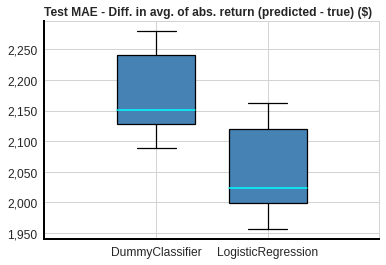

In [23]:
bxp_cols = ["label", "whislo", "q1", "med", "q3", "whishi", "fliers"]
boxes = [
    df_cost_funcs.loc[
        bxp_cols, type(best_dummy_pipe.named_steps["clf"]).__name__
    ].to_dict(),
    df_cost_funcs.loc[bxp_cols, type(best_pipe.named_steps["clf"]).__name__].to_dict(),
]
plot_boxplot_using_quantiles(
    boxes, "Test MAE - Diff. in avg. of abs. return (predicted - true) ($)", 12, (6, 4)
)

In [24]:
df_scores, y_pred_test_selected_threshold = get_eval_metrics(
    y_test.to_numpy(), y_probs_test, split="test", threshold=best_t, beta=2
)
display(df_scores.T)

,0
test_recall_binary,0.140599
test_fpr,0.044681
test_f2,0.167968
test_pr_auc,0.266649
test_roc_auc,0.547959


In [25]:
df_cm = (
    pd.DataFrame(
        mr.confusion_matrix(
            y_test,
            y_pred_test_selected_threshold,
            labels=np.sort(np.unique(y_train_val)),
        ),
        index=np.sort(np.unique(y_train_val)),
        columns=np.sort(np.unique(y_train_val)),
    )
    .rename_axis("actual", axis="columns")
    .rename_axis("predicted", axis="rows")
)
df_cr = pd.DataFrame(
    mr.classification_report(
        y_test,
        y_pred_test_selected_threshold,
        target_names=np.sort(np.unique(y_train_val)),
        output_dict=True,
    )
).T
plot_altair_grid(
    df_cm,
    df_cr,
    ptitle_offset=-5,
    cpe_figsize=(150, 300),
    cm_figsize=(150, 300),
    cr_figsize=[(250, 300), (100, 300)],
)

alt.HConcatChart(...)

**Observations**
1. The poor performance based on these ML scoring metrics is not surprising since the threshold was optimized on the cost function of MAE. Each of these metrics had an optimal threshold region that was different from the threshold that minimized the MAE.
2. By definition, `TPR` and `F2` are close to eachother since they minimize `FN`. This was also seen earlier in the metric-based threshold tuning plots.

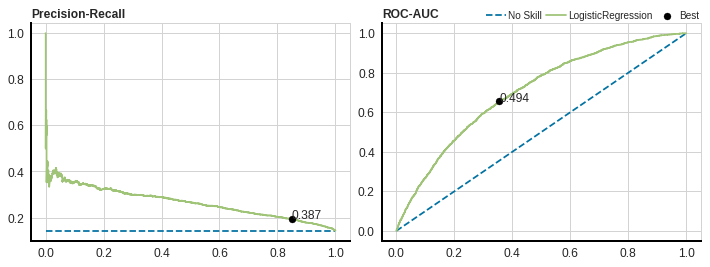

In [26]:
plot_pr_roc_curves(
    y_test,
    y_probs_test,
    type(best_pipe.named_steps["clf"]).__name__,
    axis_tick_label_fontsize=12,
    wspace=0.1,
    legend_position=(0.3, 1.1),
    f2_beta=2,
    fig_size=(12, 4),
)

**Observations**
1. Interpreting the ROC-AUC curve
   - On average, a model with skill gives a higher probability to a randomly chosen real positive outcome than a negative one.
   - A model with perfect skill is depicted as a point at `(0, 1)` (top left of the plot)
     - A model with skill produces a ROC-AUC curve that expands from the 45-degree line up to the top left of the plot.
2. Interpreting the Precision-Recall curve
   - A model with skill can discriminate between classes and does not predict a random class or a constant class in all cases.
   - The no-skill line is a horizontal line with the value of the ratio of positive cases in the dataset. Its value depends on the relative balance between positive to negative classes. For a prefectly balanced dataset, this ratio is 0.5, which is clearly not the case here.
     - for the test set here, `y_test.value_counts().to_dict()` gives `{0: 10698, 1: 1771}` and so the no-skill line is drawn at `1771/10698 = 0.1655`
   - A model with perfect skill is depicted as a point at `(1, 1)` (top right of the plot)
   - A model with skill produces a Precision-Recall curve that expands from the horizontal line, at the bottom, to the top right of the plot and is well above the horizontal line of no skill.
3. Given the imbalance in the classes here, more importance should be given to the Precision-Recall curve than to the ROC-AUC curve.
4. While both plots are clearly sub-optimal, it is reassuring that the best model found here is better than one that has no skill.
5. The optimal threshold is marked as a circle (but is not used anywhere) with an annotation on the
   - ROC-AUC curve
     - This is the threshold with the optimal balance between false positive and true positive rates as determined by optimizing the Geometric Mean
   - Precision-Recall curve
     - This is the threshold with the the best balance of precision and recall as determined by as optimizing the [F2 score](https://clusteval.sdu.dk/1/clustering_quality_measures/14)

### Proxies for Feature Importance

In this section, techniques for post-hoc interpretation to understand the ML model's predictions will be explored. Although the training split may be used for training the feature importance approach, only the test split will be used for interpretations in the following sub-sections since the predictive power of each feature on unseen data is ultimately of interest.

Note that these importances are intended to show the columns from the data that drive the model's predictions of the outcome of a loan (default or paid off on-time) but do not reflect causation.

#### Model-Neutral Permutation Importance

In permutation importance ([1](https://academic.oup.com/bioinformatics/article/26/10/1340/193348), [2](https://docs.cloud.oracle.com/en-us/iaas/tools/ads-sdk/latest/user_guide/mlx/permutation_importance.html#description)), each ML feature is separately shuffled and used as an input for modeling. The difference in scoring metric with and without this shuffling is taken as the importance of the column being randomized to the model. This process is repeated for each column individually. The larger the difference, the more important the feature to the ML model. It provides a model agnostic indication of the importance of each feature, independent of how the algorithm's coefficients/importances are computed. The method requires the absence of multi-collinearity between ML features and that is the case here as correlated features were manually removed during exploratory data analysis (see `3_*.ipynb`).

**Methodology Used**
1. For a given (`r`, `n`, `P`), calculate
   - predicted return per loan ( `A` )
     - calculate predicted return from confusion matrix, using formula for `R(t)` defined earlier
       - this takes ML model's predictive power into account
   - true return per loan (`B`)
2. Calculate difference between predicted and true return `AE`, which was defined earlier
3. Calculate mean of all differences in the testing data
   - this gives the average difference between the predicted and true return over all the loans in the test split (`MAE`, which was defined earlier)
   - this is the baseline score
4. Shuffle a single ML feature and re-calculate the mean of all differences (`MAE1`) from step 3.
4. Calculate difference (`D1`) bewteen mean values found in steps 3. (without shuffling, the baseline `MAE`) and 4. (with shuffling, `MAE1`)
5. Repeat steps 1. to 4. `n_repeats` times
   - in other words, shuffle the same column `n_repeats` times and calculate the differences (`D2`, ..., `D10`) between the predicted and true returns
6. Plot a boxplot of all the differences `D1`, ..., `D10`

Below is a boxplot highlighting the impact on model performance, separately using the TPR (minimizes `FN`), FPR and F2 score (the prefered metric for imbalanced data where `FN` is more important than `FP`) as the scoring metric, of randomizing columns from the testing data individually (i.e. as determined using the permutation importance)

In [ ]:
# !cat -n src/visualization_helpers.py | sed -n -e 1,22p -e 157,228p

CPU times: user 771 ms, sys: 1.74 s, total: 2.51 s
Wall time: 3.06 s


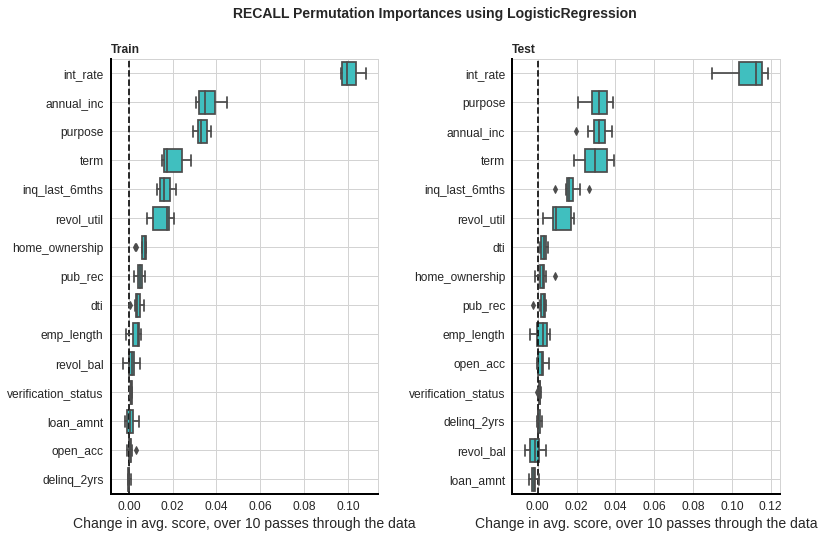

In [27]:
%%time
builtin_plot_permutation_importances(
    best_pipe,
    X_train_val,
    X_test,
    y_train_val,
    y_test,
    scorer=multi_scorers["recall_binary"],
    n_repeats=10,
    fig_title_fontsize=14,
    fig_title_vertical_pos=0.97,
    axis_tick_label_fontsize=12,
    axis_label_fontsize=14,
    box_color="cyan",
    fig_size=(12, 8),
)

CPU times: user 808 ms, sys: 1.6 s, total: 2.41 s
Wall time: 2.86 s


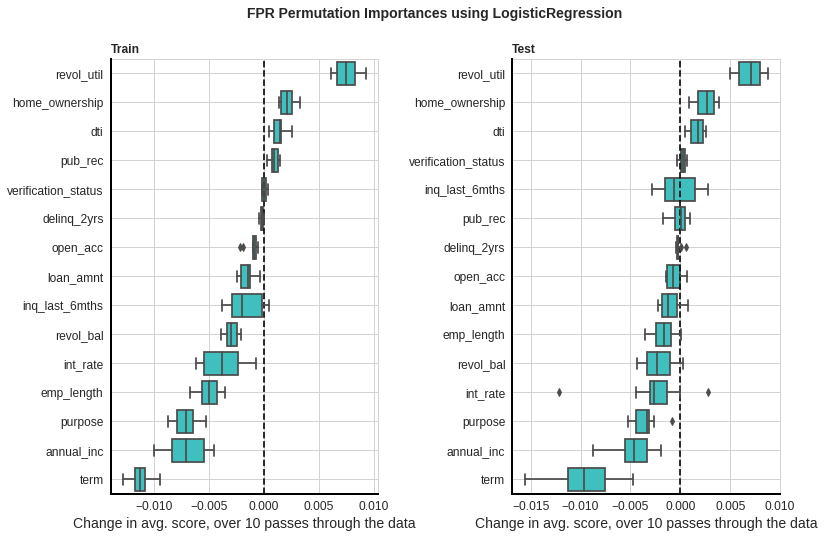

In [28]:
%%time
builtin_plot_permutation_importances(
    best_pipe,
    X_train_val,
    X_test,
    y_train_val,
    y_test,
    scorer=multi_scorers["fpr"],
    n_repeats=10,
    fig_title_fontsize=14,
    fig_title_vertical_pos=0.97,
    axis_tick_label_fontsize=12,
    axis_label_fontsize=14,
    box_color="cyan",
    fig_size=(12, 8),
)

CPU times: user 797 ms, sys: 1.64 s, total: 2.44 s
Wall time: 3.14 s


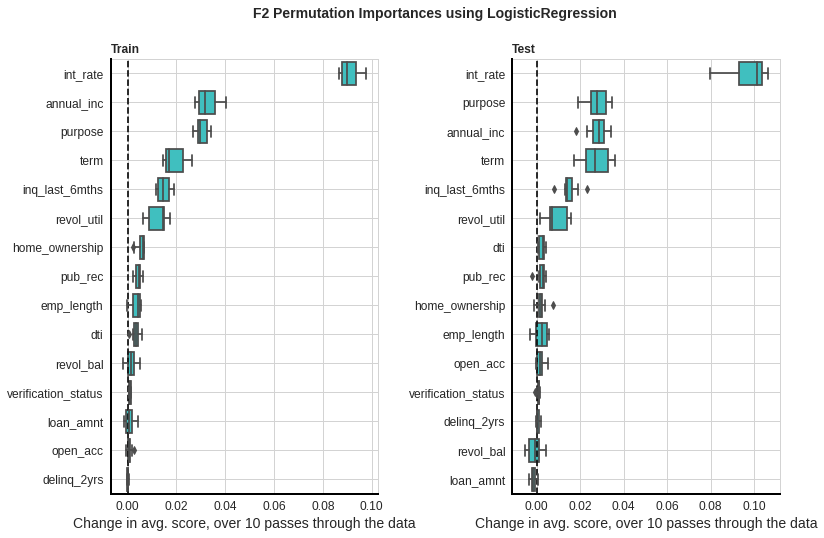

In [29]:
%%time
builtin_plot_permutation_importances(
    best_pipe,
    X_train_val,
    X_test,
    y_train_val,
    y_test,
    scorer=multi_scorers["f2"],
    n_repeats=10,
    fig_title_fontsize=14,
    fig_title_vertical_pos=0.97,
    axis_tick_label_fontsize=12,
    axis_label_fontsize=14,
    box_color="cyan",
    fig_size=(12, 8),
)

The process is repeated using the difference between the average difference of the model's predicted, and true return, per loan in the testing split as the scoring metric instead of the the TPR and FPR separately

In [ ]:
# !pygmentize src/custom_permutation_importance_helpers.py

CPU times: user 10.5 s, sys: 1.04 s, total: 11.6 s
Wall time: 1min 53s


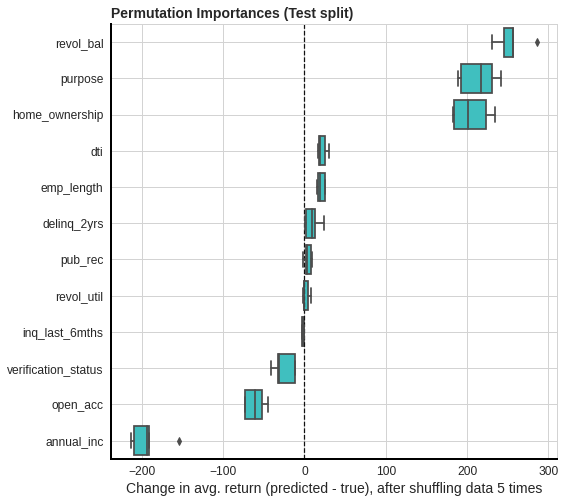

In [30]:
%%time
manual_plot_permutation_importance(
    X_test,
    y_test,
    best_pipe,
    best_t,
    5,
    "test",
    "Permutation Importances",
    14,
    12,
    14,
    "cyan",
    (8, 8),
    verbose=True,
)

**Notes**
1. The higher the absolute difference the more impactful the ML feature is to the predictive model developed here
   - a positive difference indicates the average error between the predicted and true return became larger by shuffling (the predicted return is larger than the true return by shuffling)
   - a negative difference indicates the average error between predicted and true return became larger in the negative direction by shuffling (the true return is larger than the predicted return by shuffling)
2. The `int_rate` (loan's interest rate), `term` (duration of loan) and `loan_amnt` (principal) are required to calculate the interrest income which is used in converting the model's predictions to the per-loan return. By definition, shuffling each of these columns individually will have the greatest affect this conversion. More importantly, the computation of total loan income is not sensible with unrealistic combinations of these three components. So, these three ML features are not used in determining the permutation importance.

**Observations**
1. Unsurprisingly, `annual_inc` (annual income), `purpose` (reason for wanting to borrow money) and `home_ownership` (whether the borrower is a home owner, paying a mortgage, paying rent, etc.) were among the most influential value-add variables in the data.
2. The most important feature was found to be `revol_bal`, which is the fraction of credit card spending that will not be recovered adds up over several monthly payment periods and directly affects whether a loan will be paid off on time or, due to the accumulation of missed payments, not on time - [link](https://www.creditcards.com/credit-card-news/glossary/term-revolving-balance/)). Intuitively, this makes sense.
3. The next group of important features (mid-range, or middle-of-the-pack, in terms of their importance) to a borrower's ability to pay back a loan were found to be
   - `dti` - fraction of total monthly debt relative to monthly income - [link](https://www.consumerfinance.gov/ask-cfpb/what-is-a-debt-to-income-ratio-why-is-the-43-debt-to-income-ratio-important-en-1791/)
   - `open_acc` - if a borrower is using a lot of credit lines, this could be an indication of their reliance on these to cover daily expenses and would question whether they can take on the additional debt in the form of a loan
   - `emp_length` (length of employment)
     - it was somewhat surprising that this was not higher up in its importance
   - `verification_status`
4. The weakest features were
   - `revol_util` - fraction of used credit relative to all available revolving credit
   - `inq_last_6mths` - number of times, over the last 6 months, a loan lender has reviewed a borrower's credit report as part of a loan application - [link](https://www.consumer.equifax.ca/personal/education/credit-report/understanding-hard-inquiries-on-credit-report/)
   - `delinq_2yrs`
     - number of times a greater than 30 days past-due delinquency occurred on the borrower's credit file over the last two years
   - `pub_rec`
5. Since this is the **average** difference in dollars (horizontal axis) per loan, the marginal value increases in the per-loan return between pairs of features (eg. `annual_inc` vs `purpose`) should also be interpreted as an average rather than a discrete value that can be expected for every single loan.

**Disadvantages of Permutation Importances**
1. When assessing the ML model's predictions on a permuted feature, this leads to an evaluation of observations (loans) that do not make sense in practice.i.e. loans with the randomized column values may never occur in reality. Yet, these are being cast as legitimate observatoins from the data and being used to train the ML model in order to make predictions on the outcomes of such loans.
2. At its core, the randomness being introduced may lead to the results (importances) that vary significantly. This would appear as a boxplot with a large width reflecing a significant variation from one repeat to the next and within each repeat itself. It is not observed here but, if it did, will lead to less interpretable importances from this method.

#### Drop-Column Feature / Leave One Co-variate Out (LOCO) Importance

The next approach ([LOCO](https://arxiv.org/abs/2006.08482)) is identical to permutation importance, but drops a single ML feature at a time, instead of shuffling it, and then computing the difference in the ML model's performance on unseen data. A single repeat is necessary since dropping the same feature multiple times and re-running the training/prediction gives the same output. So, the boxplot has been replaced by a bar plot. As before, the three features essential to the computation of total loan income are not included here.

In [ ]:
# !pygmentize src/custom_looc_importance_helpers.py

baseline score=2059.81

feat=emp_length, score=2058.27

feat=open_acc, score=2057.78

feat=home_ownership, score=2073.86

feat=revol_bal, score=2070.79

feat=verification_status, score=2060.73

feat=purpose, score=2079.69

feat=inq_last_6mths, score=2046.70

feat=annual_inc, score=2056.87

feat=dti, score=2046.16

feat=pub_rec, score=2059.62

feat=revol_util, score=2051.45

feat=delinq_2yrs, score=2057.77

CPU times: user 11.4 s, sys: 3.04 s, total: 14.4 s
Wall time: 34.3 s


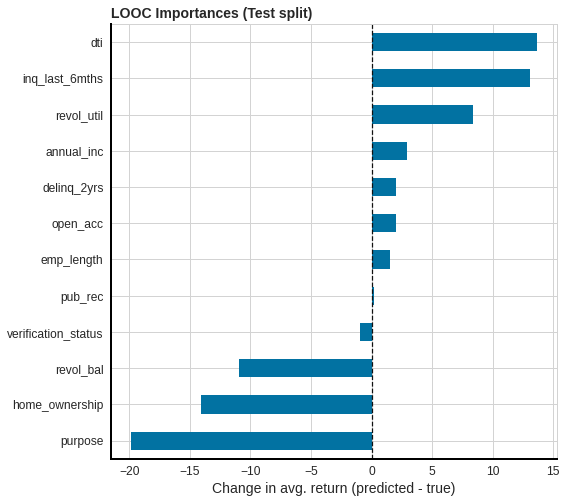

In [31]:
%%time
df_looc = manual_plot_looc_importance(
    X_train_val.copy(),
    X_test.copy(),
    y_train_val.copy(),
    y_test.copy(),
    "no_trans",
    numerical_columns,
    nominal_columns,
    df_gs["clf_obj"].iloc[0],
    best_t,
    0.5,
    "spearman",
    "test",
    "LOOC Importances",
    14,
    12,
    14,
    "cyan",
    True,
    (8, 8),
)

**Observations**
1. `purpose`, `revol_bal`, `home_ownership`, `dti` and `inq_last_6mths` are the most important features
   - `inq_last_6mths` and `dti` was among the weakest and mid-range in permutation importance respectively, but are now one of the most important
2. `emp_length` and `annual_inc` are no longer mid-range or strongest respectively in terms of their importance, but are now among the weakest
   - disagreement with permutation importances, and arguably less-intuitive now
3. `open_acc` was mid-range before and is now among the weakest
4. `revol_util` was among the weakest before and is now mid-range
4. `pub_rec` and `verification_status` are among the weakest as before
5. `delinq_2yrs` is among the weakest as before

**Disadvantages of LOCO Importances**
1. When assessing the ML model's predictions without a feature, this leads to a scenario where the ML model will be trained and it will find another way to derive the same information lost by dropping a single feature if possible. So, this approach is combining two factors - the predictive power of the feature that is dropped (which is what we want to do) but also and the way the model configures itself (which, if it occurs, is not intended)
   - in the current case, this could partially explain why `open_acc` appears to have been replaced by `total_acc` and why weaker features (upon permuting them but not dropping) appear among the more important ones here
2. In the presence of a large number of ML features, this method requires re-training the model for each feature being dropped which is computationally expensive and may not be scalable in practice.

#### **SH**apely **A**dditive ex**P**lanations (SHAP) Values

The next approach (SHAP - [article](https://proceedings.neurips.cc/paper/2017/hash/8a20a8621978632d76c43dfd28b67767-Abstract.html), [algorithm](https://arxiv.org/abs/1802.03888)) uses game theory in order to explain ML model outputs.

Attempts at using SHAP to explain a full pipeline using a model-agnostic approach were not successful as documented below.

Using `shap.Explainer(best_pipe.predict, X_train_val, model_output="margin")` produced the following error
```
Exception                                 Traceback (most recent call last)
<path-here>/shap/explainers/_linear.py in supports_model_with_masker(model, masker)
    268         try:
--> 269             Linear._parse_model(model)
    270         except e:

<path-here>/shap/explainers/_linear.py in _parse_model(model)
    255         else:
--> 256             raise Exception("An unknown model type was passed: " + str(type(model)))
    257 

Exception: An unknown model type was passed: <class 'function'>

During handling of the above exception, another exception occurred:

NameError                                 Traceback (most recent call last)
<ipython-input-76-73e9cfc6d076> in <module>
----> 1 explainer_pipe = shap.Explainer(best_pipe.predict, X_train_val, model_output="margin")

<path-here>/shap/explainers/_explainer.py in __init__(self, model, masker, link, algorithm, output_names, feature_names, **kwargs)
     97 
     98                 # use implementation-aware methods if possible
---> 99                 if explainers.Linear.supports_model_with_masker(model, self.masker):
    100                     algorithm = "linear"
    101                 elif explainers.Tree.supports_model_with_masker(model, self.masker): # TODO: check for Partition?

<path-here>/shap/explainers/_linear.py in supports_model_with_masker(model, masker)
    268         try:
    269             Linear._parse_model(model)
--> 270         except e:
    271             return False
    272         return True

NameError: name 'e' is not defined
```

Using `shap.Explainer(best_pipe, X_train_val, model_output="margin")` produced the following error
```
---------------------------------------------------------------------------
Exception                                 Traceback (most recent call last)
<path-here>/shap/explainers/_linear.py in supports_model_with_masker(model, masker)
    268         try:
--> 269             Linear._parse_model(model)
    270         except e:

<path-here>/shap/explainers/_linear.py in _parse_model(model)
    255         else:
--> 256             raise Exception("An unknown model type was passed: " + str(type(model)))
    257 

Exception: An unknown model type was passed: <class 'sklearn.pipeline.Pipeline'>

During handling of the above exception, another exception occurred:

NameError                                 Traceback (most recent call last)
<ipython-input-77-02c8ee0c218e> in <module>
----> 1 explainer_pipe = shap.Explainer(best_pipe, X_train_val, model_output="margin")

<path-here>/shap/explainers/_explainer.py in __init__(self, model, masker, link, algorithm, output_names, feature_names, **kwargs)
     97 
     98                 # use implementation-aware methods if possible
---> 99                 if explainers.Linear.supports_model_with_masker(model, self.masker):
    100                     algorithm = "linear"
    101                 elif explainers.Tree.supports_model_with_masker(model, self.masker): # TODO: check for Partition?

<path-here>/shap/explainers/_linear.py in supports_model_with_masker(model, masker)
    268         try:
    269             Linear._parse_model(model)
--> 270         except e:
    271             return False
    272         return True

NameError: name 'e' is not defined
```

Using `shap.KernelExplainer(best_pipe.predict_proba, X_train_val)` gave the following error
```
Provided model function fails when applied to the provided data set.

---------------------------------------------------------------------------
Empty                                     Traceback (most recent call last)
<path>/joblib/parallel.py in dispatch_one_batch(self, iterator)
    826             try:
--> 827                 tasks = self._ready_batches.get(block=False)
    828             except queue.Empty:

/usr/lib/python3.8/queue.py in get(self, block, timeout)
    166                 if not self._qsize():
--> 167                     raise Empty
    168             elif timeout is None:

Empty: 

During handling of the above exception, another exception occurred:

ValueError                                Traceback (most recent call last)
<ipython-input-80-911d12bf49fc> in <module>
----> 1 explainer_pipe = shap.KernelExplainer(best_pipe.predict_proba, X_train_val)

<path>/shap/explainers/_kernel.py in __init__(self, model, data, link, **kwargs)
     66         self.keep_index_ordered = kwargs.get("keep_index_ordered", False)
     67         self.data = convert_to_data(data, keep_index=self.keep_index)
---> 68         model_null = match_model_to_data(self.model, self.data)
     69 
     70         # enforce our current input type limitations

<path>/shap/utils/_legacy.py in match_model_to_data(model, data)
    110             out_val = model.f(data.convert_to_df())
    111         else:
--> 112             out_val = model.f(data.data)
    113     except:
    114         print("Provided model function fails when applied to the provided data set.")

<path>/sklearn/utils/metaestimators.py in <lambda>(*args, **kwargs)
    117 
    118         # lambda, but not partial, allows help() to work with update_wrapper
--> 119         out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)
    120         # update the docstring of the returned function
    121         update_wrapper(out, self.fn)

<path>/sklearn/pipeline.py in predict_proba(self, X)
    461         Xt = X
    462         for _, name, transform in self._iter(with_final=False):
--> 463             Xt = transform.transform(Xt)
    464         return self.steps[-1][-1].predict_proba(Xt)
    465 

<path>/sklearn/compose/_column_transformer.py in transform(self, X)
    602         # TODO: also call _check_n_features(reset=False) in 0.24
    603         self._validate_features(X.shape[1], X_feature_names)
--> 604         Xs = self._fit_transform(X, None, _transform_one, fitted=True)
    605         self._validate_output(Xs)
    606 

<path>/sklearn/compose/_column_transformer.py in _fit_transform(self, X, y, func, fitted)
    456             self._iter(fitted=fitted, replace_strings=True))
    457         try:
--> 458             return Parallel(n_jobs=self.n_jobs)(
    459                 delayed(func)(
    460                     transformer=clone(trans) if not fitted else trans,

<path>/joblib/parallel.py in __call__(self, iterable)
   1046             # remaining jobs.
   1047             self._iterating = False
-> 1048             if self.dispatch_one_batch(iterator):
   1049                 self._iterating = self._original_iterator is not None
   1050 

<path>/joblib/parallel.py in dispatch_one_batch(self, iterator)
    836                 big_batch_size = batch_size * n_jobs
    837 
--> 838                 islice = list(itertools.islice(iterator, big_batch_size))
    839                 if len(islice) == 0:
    840                     return False

<path>/sklearn/compose/_column_transformer.py in <genexpr>(.0)
    459                 delayed(func)(
    460                     transformer=clone(trans) if not fitted else trans,
--> 461                     X=_safe_indexing(X, column, axis=1),
    462                     y=y,
    463                     weight=weight,

<path>/sklearn/utils/__init__.py in _safe_indexing(X, indices, axis)
    385 
    386     if axis == 1 and indices_dtype == 'str' and not hasattr(X, 'loc'):
--> 387         raise ValueError(
    388             "Specifying the columns using strings is only supported for "
    389             "pandas DataFrames"

ValueError: Specifying the columns using strings is only supported for pandas DataFrames
```

So, the transformation steps of the pipeline were [first applied](https://github.com/slundberg/shap/issues/1373#issuecomment-676788860) and then SHAP was used to only explain the ML model step of the pipeline

In [ ]:
# !pygmentize src/preprocessing_helpers.py

In [32]:
pipe_clf, X_train_val_trans, X_test_trans = get_transformed_data(
    df_gs["clf_obj"].iloc[0],
    best_pipe,
    X_train_val,
    y_train_val,
    X_test,
    "no_trans",
    numerical_columns,
    nominal_columns,
    0.5,
    "spearman",
)

A correlation heatmap below shows that pre-processed features don't have correlations above the specified threshold

In [ ]:
# !cat -n src/visualization_helpers.py | sed -n -e 1,22p -e 611,639p

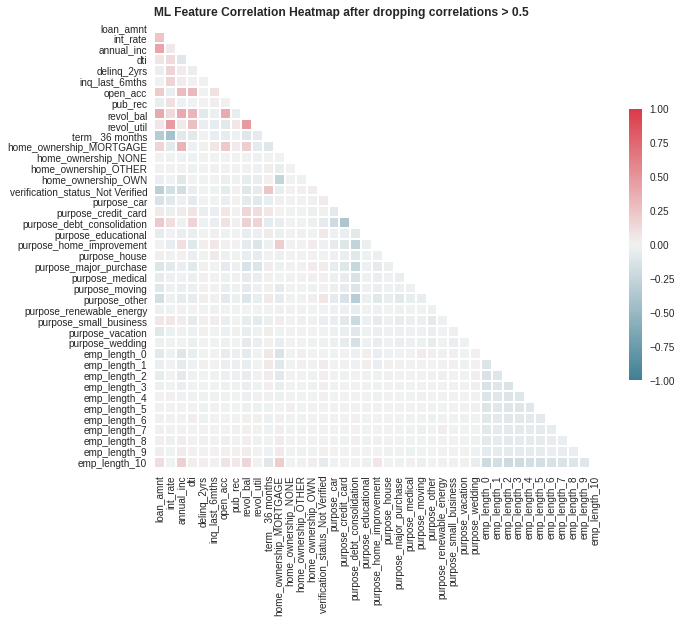

In [33]:
plot_lower_corr_heatmap(
    X_train_val_trans.corr(method="spearman"),
    "ML Feature Correlation Heatmap after dropping correlations > 0.5",
    1,
    {False: None},
    1,
    True,
    0.5,
    fig_size=(10, 10),
)

A SHAP explainer is now instantiated using only the ML step from the overall pipeline and SHAP values are obtained

In [180]:
%%time
explainer = shap.Explainer(
    pipe_clf.named_steps["clf"], X_train_val_trans, model_output="margin"
)
shap_values = explainer.shap_values(X_test_trans)

CPU times: user 6.05 ms, sys: 1.18 ms, total: 7.23 ms
Wall time: 6.54 ms


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


SHAP summary plots are shown below

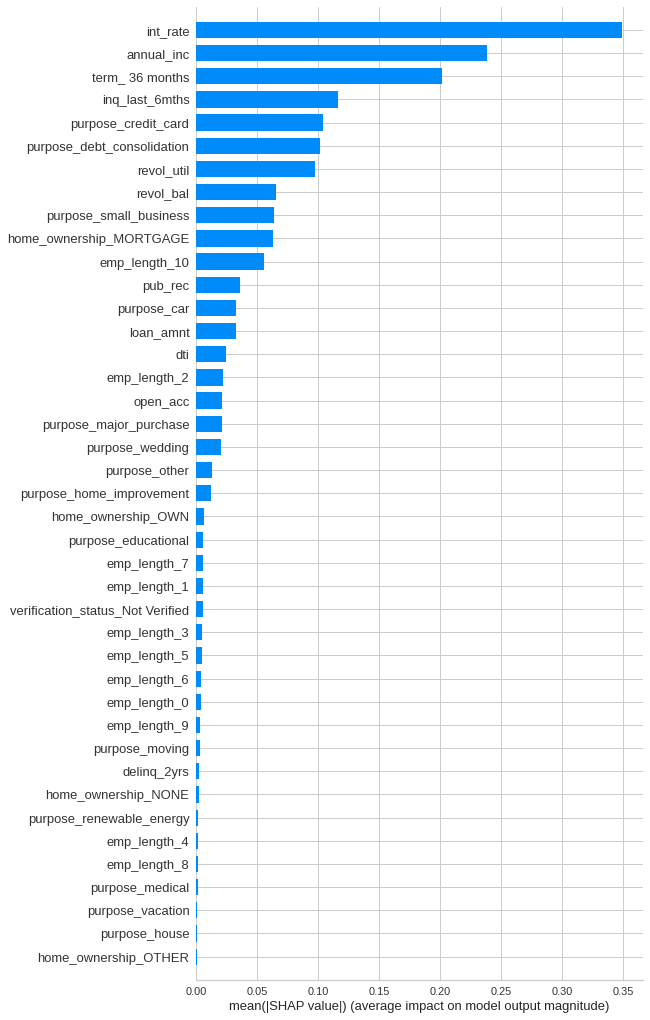

CPU times: user 301 ms, sys: 167 ms, total: 468 ms
Wall time: 259 ms


In [38]:
%%time
shap.summary_plot(
    shap_values=shap_values, features=X_test_trans, max_display=X_test_trans.shape[1], plot_type="bar"
)

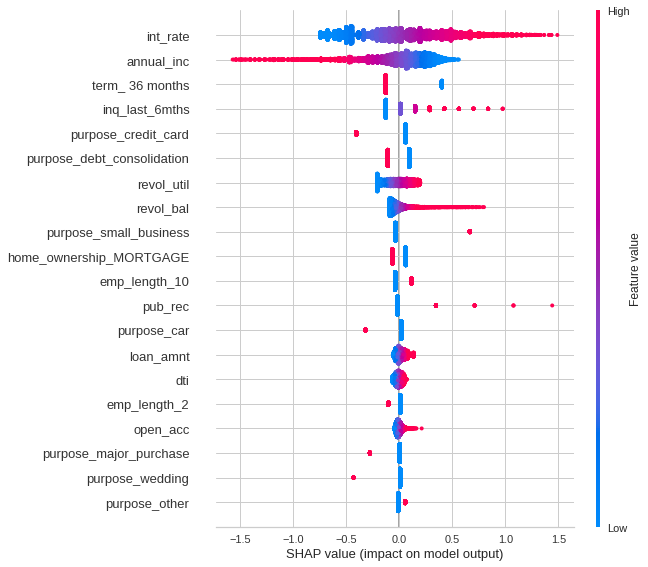

CPU times: user 1.56 s, sys: 922 ms, total: 2.48 s
Wall time: 1.35 s


In [36]:
%%time
shap.summary_plot(
    shap_values=shap_values, features=X_test_trans, max_display=20, plot_type="dot"
)

**Observations**

For the following observations, the three features required to compute total loan income - principal, interest rate and loan term (either among the most important or mid-range here) are excluded for consistency with previous feature importance methods
1. `inq_last_6mths`, `annual_inc` and `purpose` are the most important features
   - `inq_last_6mths` and `annual_inc` were among the strongest in LOCO and weakest in permutation importance
   - `purpose` shows up numerous times and has consistently been the most important feature in all feature importance methods investigated
2. `emp_length` of 10 years is mid-range here, previously the overall feature was weak or mid-range
   - the other `emp_length` values are among the weakest features
3. `revol_bal` is middle-of-the pack in terms of SHAPely values, while previously it was among the strongest
4. `revol_util` was weak or mid-range and is now among the most-important
5. `delinq_2yrs` and `open_acc` are the weakest features in terms of SHAPely values, previously being mid-range at best
6. `dti` is among the weakest, compared to being among the strongest or mid-range previously
7. `home_ownership` (non-MORTGAGE) are now weakest, while the MORTGAGE option is mid-range
   - the overall feature was previously among the strongest
8. `emp_length` was among the weakest in permutation importance and mid-range in LOCO; now it is weakest again
9. `pub_rec` is mid-range compared to previously being among the weakest

#### Overall Observations about ML Feature Importances

In [50]:
X_train_val.sort_index().head()

,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util
0,5000.0,36 months,10.65,10,RENT,24000.0,Verified,credit_card,27.65,0.0,1.0,3.0,0.0,13648.0,83.7
5,5000.0,36 months,7.90,3,RENT,36000.0,Source Verified,wedding,11.20,0.0,3.0,9.0,0.0,7963.0,28.3
7,3000.0,36 months,18.64,9,RENT,48000.0,Source Verified,car,5.35,0.0,2.0,4.0,0.0,8221.0,87.5
8,5600.0,60 months,21.28,4,OWN,40000.0,Source Verified,small_business,5.55,0.0,2.0,11.0,0.0,5210.0,32.6
10,6500.0,60 months,14.65,5,OWN,72000.0,Not Verified,debt_consolidation,16.12,0.0,2.0,14.0,0.0,4032.0,20.6


In [51]:
X_test.sort_index().head()

,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util
1,2500.0,60 months,15.27,0,RENT,30000.0,Source Verified,car,1.00,0.0,5.0,3.0,0.0,1687.0,9.4
2,2400.0,36 months,15.96,10,RENT,12252.0,Not Verified,small_business,8.72,0.0,2.0,2.0,0.0,2956.0,98.5
3,10000.0,36 months,13.49,10,RENT,49200.0,Source Verified,other,20.00,0.0,1.0,10.0,0.0,5598.0,21.0
6,7000.0,60 months,15.96,8,RENT,47004.0,Not Verified,debt_consolidation,23.51,0.0,1.0,7.0,0.0,17726.0,85.6
9,5375.0,60 months,12.69,0,RENT,15000.0,Verified,other,18.08,0.0,0.0,2.0,0.0,9279.0,36.5


In [53]:
(X_train_val["loan_amnt"].median(), X_train_val["loan_amnt"].max()), (
    X_test["loan_amnt"].median(),
    X_test["loan_amnt"].max(),
)

((9925.0, 35000.0), (10000.0, 35000.0))

In [54]:
(X_train_val["emp_length"].median(), X_train_val["emp_length"].max()), (
    X_test["emp_length"].median(),
    X_test["emp_length"].max(),
)

((4.0, 10), (4.0, 10))

Below, ML features in green are consistently among the most important while those in red are least important. Those shown in blue are not unanimously among the most or least important and it is not clear where they stand in this regard
1. The three columns requried to caculate the total loan income - <span style="color:green">loan_amnt</span>, <span style="color:green">term</span> and <span style="color:green">int_rate</span> - are essential to scoring the model's predictions and, in that sense, are important. They have only been tested in SHAPely values, where `term` and `int_rate` were among the most important and `loan_amnt` was mid-range.
2. <span style="color:green">purpose</span>, <span style="color:green">inq_last_6mths</span>, <span style="color:green">annual_inc</span>, <span style="color:green">revol_util</span> and <span style="color:green">revol_bal</span> are among the most important features
   - `revol_util` and `inq_last_6mths` was weakest in permutation importance; it may be that shuffling loan records and arriving at unrealistic combinations of other factors with `inq_last_6mths` led to its relatively weaker importance
   - the opposite is true for `annual_inc`, where shuffling its records placed it as the most important, but dropping it only placed it as one of the weaker ML features
3. <span style="color:green">dti</span> is next in line, a consistently mid-range or important (permutation importance) feature in terms of its importance to the ML model
4. <span style="color:green">home_ownership</span> and <span style="color:red">emp_length</span> are posisbly specific in their importances
   - SHAP places them among the weakest features, except for one category each
     - MORTGAGE and 10 years respectively
   - previously `home_ownership` was among the mid-range to most important and `emp_length` was mid-range to weak
   - it may be that the max `loan_amnt` being asked for, $35,000, is not high enough to warrant using the borrower's home as collateral or emphasizing borrowers who have been working for a long time. This could explain why `home_ownership` (home values are in the hundreds of thousands) and `emp_length` (max. of 10 years) have been at best- middle-of-the-pack in their importance to the model on predicting unseen data.

5. <span style="color:red">delinq_2yrs</span>, <span style="color:red">pub_rec</span> and <span style="color:red">open_acc</span> are among the weakest, or mid-range at best
   - at best, they've been mid-range in their importance so it is not unrealistic to suggest that they fall close to the unimportant list rather than to the important ones

#### Considerations about Re-Training with subset of Features

The need to reduce the number of ML features is driven by the benefits of assembling the most parsimonious ML model ([1](https://www.statology.org/parsimonious-model/), [2](https://www.statisticshowto.com/parsimonious-model/)). This requires that sufficient performance be achieved with the simplest possible ML model. The benefits of such a model are
- faster training speed (shorter time)
- easier to interpret

Here, including all the features is not the source of a significantly long training time. So, it is still possible to provide interpretations with all features included. Furthermore, it is not unanimous as to the relative positioning of a handful of features so it could well be that their contribution to the model's predictions on unseen data, while not significant, is not insignificant either. With these two considerations in mind, all the features using the ML model development should be retained for inference.

### Check of ML Bias-Variance Tradeoff using Learning Curves

In order to explore the [tradeoff between bias and variance of the ML model's predictions](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff), the training and cross-validation learning curves are shown below

In [55]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
X_all = pd.concat([X_train_val.iloc[:, :], X_test.iloc[:, :]]).reset_index(drop=True)
y_all = pd.concat([y_train_val[:], y_test[:]]).reset_index(drop=True)

In [56]:
multi_scorers = {
    "recall_binary": mr.make_scorer(
        threshold_recall_score,
        greater_is_better=True,
        needs_proba=True,
        threshold=best_t,
    ),
    "f2": mr.make_scorer(
        threshold_fpr_score,
        greater_is_better=False,
        needs_proba=True,
        threshold=best_t,
    ),
    "fpr": mr.make_scorer(
        threshold_f2_score,
        greater_is_better=False,
        needs_proba=True,
        threshold=best_t,
    ),
}

First, these are shown using the `TPR` (or `Recall`) as the scoring metric

In [57]:
# !cat -n src/visualization_helpers.py | sed -n -e 1,22p -e 44,154p

CPU times: user 329 ms, sys: 115 ms, total: 445 ms
Wall time: 5.65 s


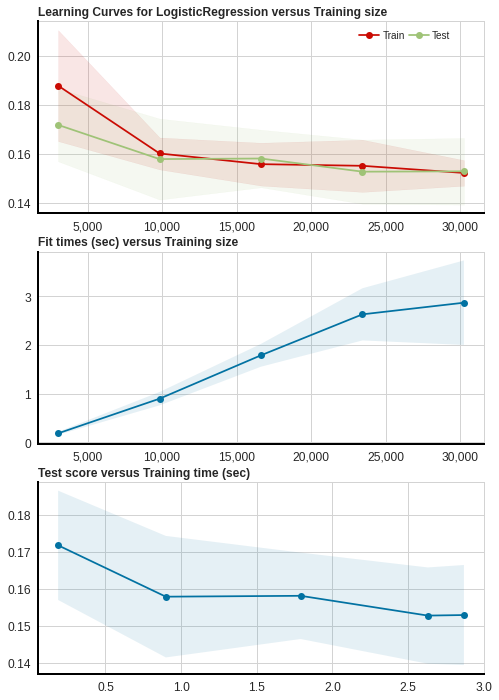

In [58]:
%%time
plot_learning_curve(
    best_pipe,
    f"Learning Curves for {type(best_pipe.named_steps['clf']).__name__}",
    X=X_all,
    y=y_all,
    cv=cv,
    scorer=multi_scorers["recall_binary"],
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5),
    legend_coords=(0.7, 1),
    axis_tick_label_fontsize=12,
    fig_size=(8, 12),
)

These are now shown using the `FPR` as the scoring metric

CPU times: user 270 ms, sys: 32.5 ms, total: 303 ms
Wall time: 4.57 s


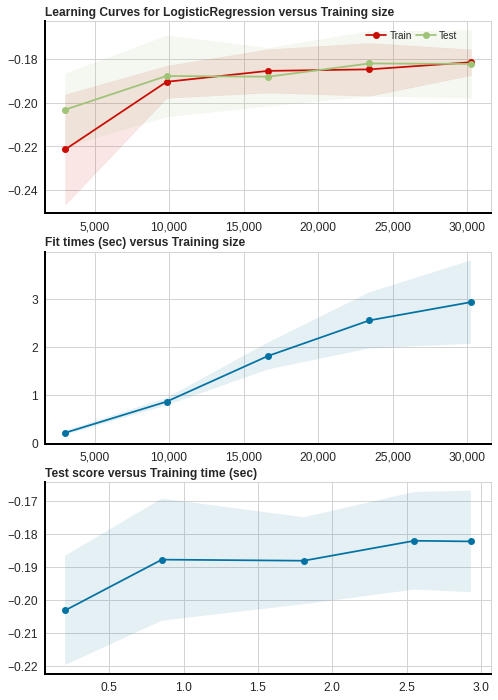

In [59]:
%%time
plot_learning_curve(
    best_pipe,
    f"Learning Curves for {type(best_pipe.named_steps['clf']).__name__}",
    X=X_all,
    y=y_all,
    cv=cv,
    scorer=multi_scorers["fpr"],
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5),
    legend_coords=(0.7, 1),
    axis_tick_label_fontsize=12,
    fig_size=(8, 12),
)

Lastly, these are now shown using the `F2` score as the scoring metric

CPU times: user 323 ms, sys: 24.3 ms, total: 347 ms
Wall time: 4.79 s


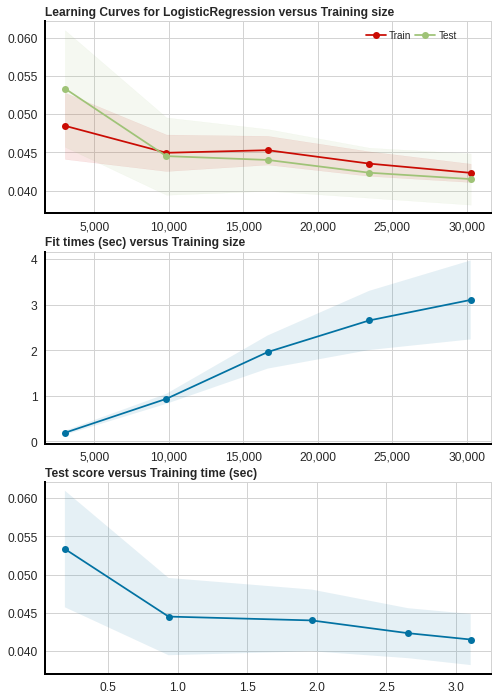

In [60]:
%%time
plot_learning_curve(
    best_pipe,
    f"Learning Curves for {type(best_pipe.named_steps['clf']).__name__}",
    X=X_all,
    y=y_all,
    cv=cv,
    scorer=multi_scorers["f2"],
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5),
    legend_coords=(0.7, 1),
    axis_tick_label_fontsize=12,
    fig_size=(8, 12),
)

As with the ML feature permutation importances, poor performance is expected for these metrics since the discrimination threshold was not chosen to optimize any of them. Instead, the focus was on the MAE in total loan income (the average difference between the predicted and true returns per loan). So, these learning curves are now repeated using this as the scoring metric

In [ ]:
# !pygmentize src/custom_learning_curve_helpers.py

done
done
done
done


,train_size|,train_err|mean,train_err|std,test_err|mean,test_err|std,fit_time|mean,fit_time|std,clf|first
0,7565,1984.169324,40.671423,2009.700326,42.125313,0.232920,0.036832,LogisticRegression
1,15132,2000.247589,21.970987,2034.759903,77.554727,0.427838,0.294540,LogisticRegression
2,22697,1987.215176,37.865154,1993.291045,87.235301,0.665844,0.416201,LogisticRegression
3,30264,1998.596874,24.563134,2014.303477,67.840355,1.061726,0.583396,LogisticRegression


CPU times: user 226 ms, sys: 58.9 ms, total: 285 ms
Wall time: 2min 43s


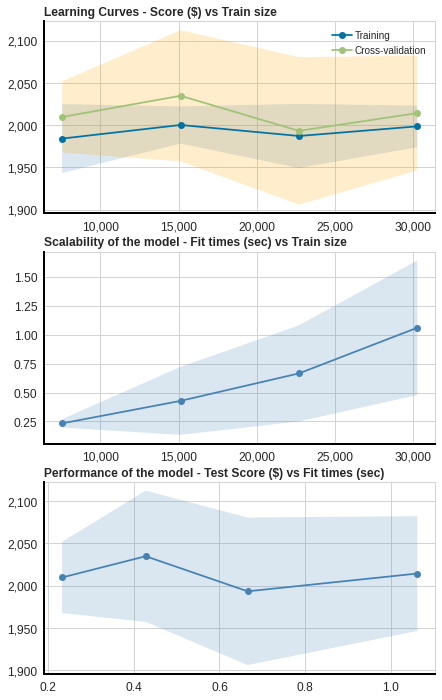

In [68]:
%%time
scores, train_sizes = learning_curve(
    best_pipe,
    X_all,
    y_all,
    cv,
    learning_curve_train_size_blocks,
    best_t,
    verbose=True,
)
scores_grouped = scores.groupby(["train_size"]).agg({"train_err": ["mean", "std"], "test_err": ["mean", "std"], "fit_time": ["mean", "std"], "clf":"first"}).reset_index()
scores_grouped.columns = scores_grouped.columns.map('|'.join)
display(scores_grouped)
manual_learning_curve(
    scores_grouped,
    alpha=0.2,
    hspace=0.2,
    wspace=0.2,
    axis_tick_label_fontsize=12,
    figsize=(7, 12),
)

In [ ]:
# !cat -n src/visualization_helpers.py | sed -n -e 1,22p -e 642,656p

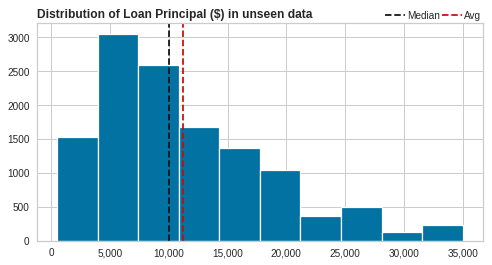

In [61]:
plot_single_column_histogram(
    X_test,
    "loan_amnt",
    "Distribution of Loan Principal ($) in unseen data",
    (8, 4),
)

**Observations**
1. Both training and cross-validation MAEs are just larger than approximately $\$$2,000. The average and median loan principal requested in data not seen by the model are approximately $\$$11,000 and $\$$10,000 respectively.

   If the investor's acceptable level of risk requires that the ML model predict the outcome of a loan (paid off on-time or defaulted) such that the
   - MAE in unseen data is within $\$$2,000
   - relative MAE in unseen data is within 10% of the average loan principal
     - ML model's predicted relative MAE is $\$$2,000 / $\$$11,000 ~ 18%
   
   then the average error per loan in the ML model's predictions (both on training and cross-validation splits of the data) would be considered too high to be acceptable. This is an indication that the model's predictions suffer from high bias.
2. The gap between the two learning curves is small, indicating the presence of low variance in the model's predictions.
3. Combined, this indicates that the best model with the selected discrimination threshold is underfitting the training data. Adding data is unlikely to remedy this problem. This is seen from the convergence of the two learning curves as the size of the training data is increased.

<a name="myfootnote1">1</a>: or loss, depending on whether the loan is paid off on time or not

### Exploring Mis-Classified (Incorrectly Predicted) Rows in data not seen by the ML model

Finally, the observations from the testing split (data not seen to any part of the ML model development process) are explored.

First, the `addr_state` feature (US state of the loan borrower) that was not used in the ML model is joined to the testing split of the data. This will allow misclassifications to be assessed by state as well as by the features used by the ML model

In [62]:
y_pred_test_selected_threshold_series = pd.Series(
    y_pred_test_selected_threshold, index=X_test.index, name="pred"
)
df_tp = df[["addr_state"]].merge(
    pd.concat(
        [
            X_test[
                [
                    "purpose",
                    "home_ownership",
                    "emp_length",
                    "term",
                ]
                + numerical_columns
            ],
            y_test,
            y_pred_test_selected_threshold_series,
        ],
        axis=1,
    ),
    left_index=True,
    right_index=True,
    how="inner",
)

Next, a mis-classification column is added to the joined data

In [63]:
df_tp["misclassified"] = df_tp["is_default"] != df_tp["pred"]
display(df_tp)
display(df_tp.dtypes.to_frame())

,addr_state,purpose,home_ownership,emp_length,term,loan_amnt,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,is_default,pred,misclassified
1,GA,car,RENT,0,60 months,2500.0,15.27,30000.0,1.00,0.0,5.0,3.0,0.0,1687.0,9.4,1,0,True
2,IL,small_business,RENT,10,36 months,2400.0,15.96,12252.0,8.72,0.0,2.0,2.0,0.0,2956.0,98.5,0,1,True
3,CA,other,RENT,10,36 months,10000.0,13.49,49200.0,20.00,0.0,1.0,10.0,0.0,5598.0,21.0,0,0,False
6,NC,debt_consolidation,RENT,8,60 months,7000.0,15.96,47004.0,23.51,0.0,1.0,7.0,0.0,17726.0,85.6,0,0,False
9,TX,other,RENT,0,60 months,5375.0,12.69,15000.0,18.08,0.0,0.0,2.0,0.0,9279.0,36.5,1,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39770,IN,credit_card,MORTGAGE,7,36 months,5300.0,8.38,74000.0,14.37,0.0,0.0,15.0,0.0,6844.0,14.4,0,0,False
39772,NY,home_improvement,MORTGAGE,2,36 months,3000.0,10.28,200000.0,0.00,1.0,0.0,5.0,0.0,0.0,0.0,0,0,False
39775,WI,home_improvement,MORTGAGE,0,36 months,5000.0,8.07,180000.0,5.55,0.0,0.0,12.0,0.0,40934.0,26.3,0,0,False
39776,WI,home_improvement,MORTGAGE,2,36 months,5000.0,9.33,180000.0,11.93,0.0,1.0,16.0,0.0,60568.0,39.2,0,0,False


,0
addr_state,object
purpose,object
home_ownership,object
emp_length,int64
term,object
loan_amnt,float64
int_rate,float64
annual_inc,float64
dti,float64
delinq_2yrs,float64


Numerical, or continuous features, are now explored using histograms. This grid of plots shows the distribution of the defaulted loans (LHS) for both misclassified (`M`) and all (`All`) the loans, and similarly for the paid on-time loans (RHS)

In [64]:
# !cat -n src/visualization_helpers.py | sed -n -e 1,22p -e 456,502p

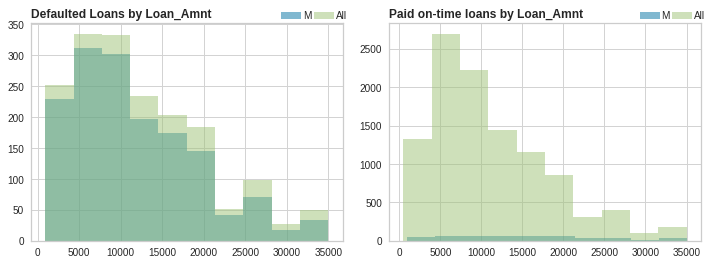

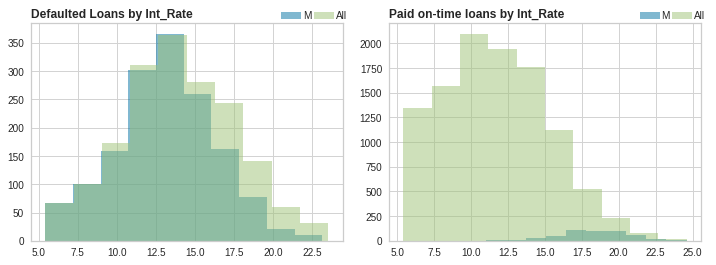

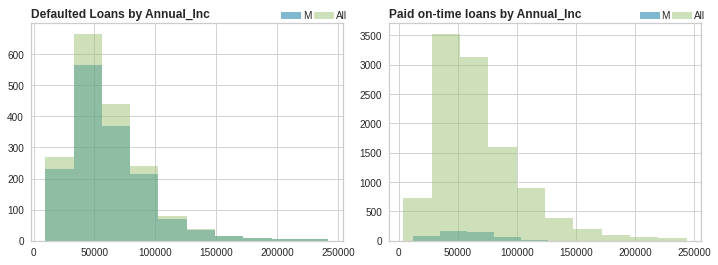

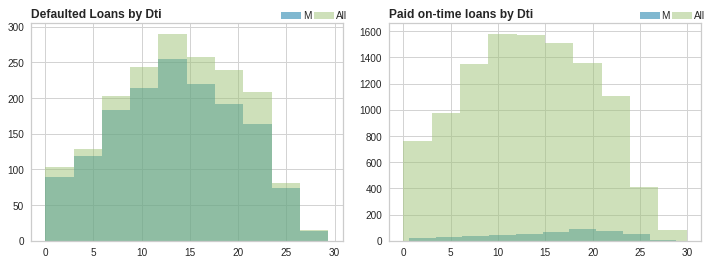

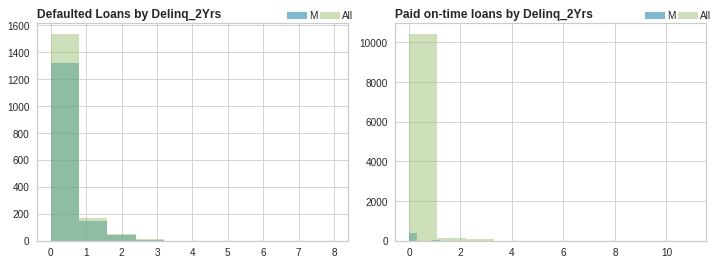

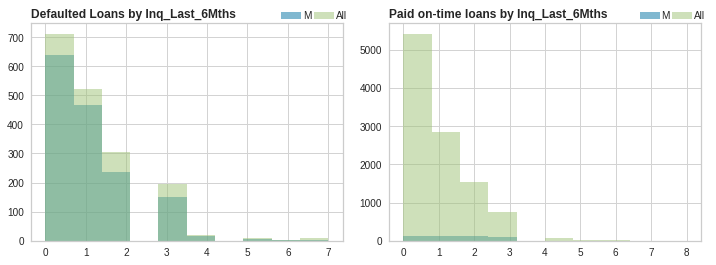

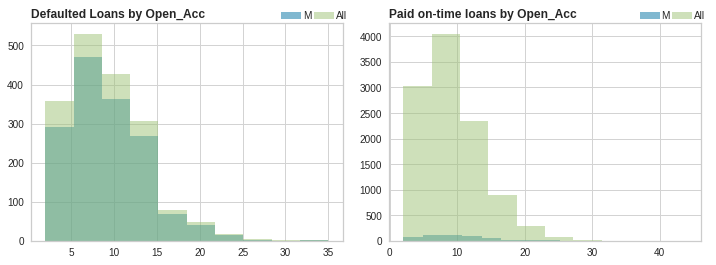

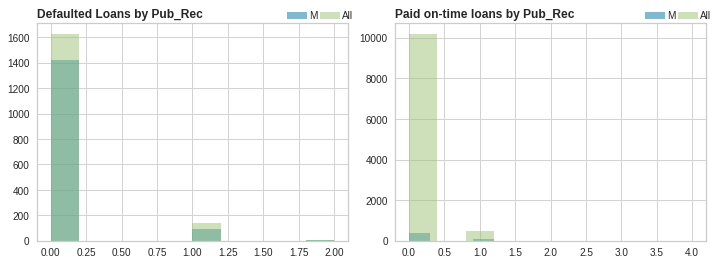

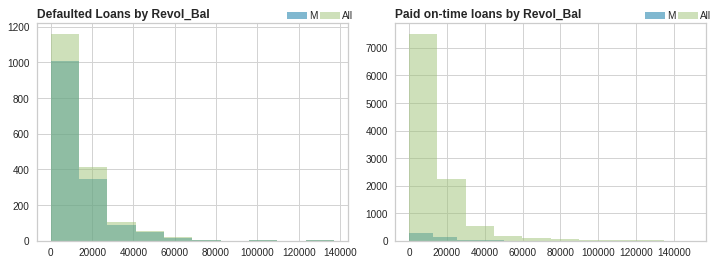

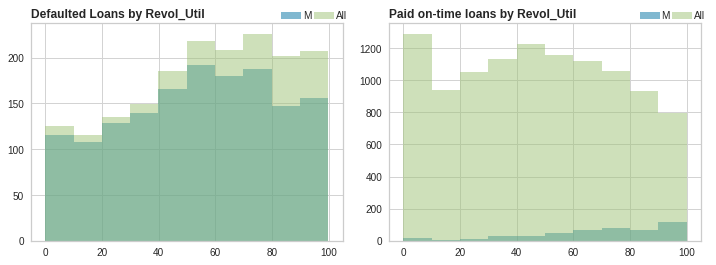

In [65]:
for c in numerical_columns:
    plot_grouped_histogram(df_tp, c, (0.775, 1.1), 0.5, 0.15, (12, 4))

**Observations**
1. In the defaults plot (LHS), the distributions are very similar in shape to those expected based on the shapes in the overall dataset
2. In the paid on-time loans plots (RHS), due to the class imbalance, there are a significantly smaller number of misclassified loans compared to all loans since it is easer to get these predictions correct
   - the shapes are similar except for
     - `int_rate`, where misclassifications occur for a higher average interest rate of approx. 18% compared to an average value of 11% when all the data is considered
     - `revol_util`, where a peak-shaped distribution seen in all the data while the misclassifications are generally increasing as the feature increases

Next, the categorical features are shown. They are expressed as bar charts showing the frequency (number) of occurrences in the misclassifications (LHS) and overall data (RHS)

In [66]:
# !cat -n src/visualization_helpers.py | sed -n -e 1,22p -e 427,453p

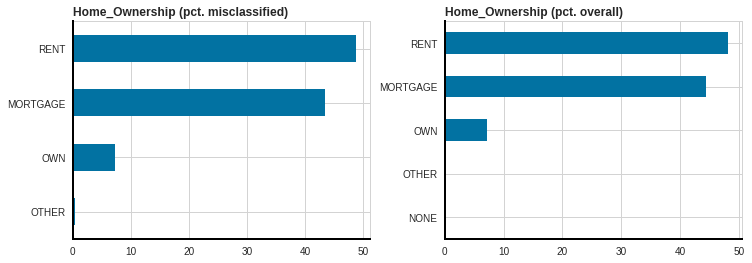

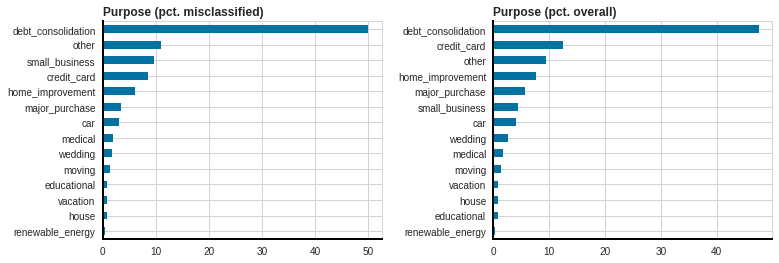

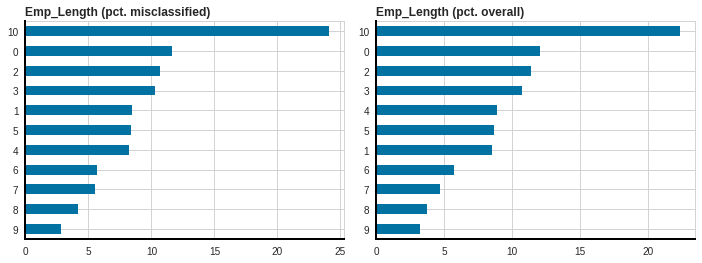

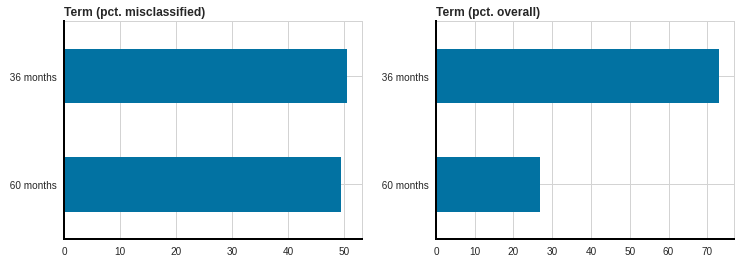

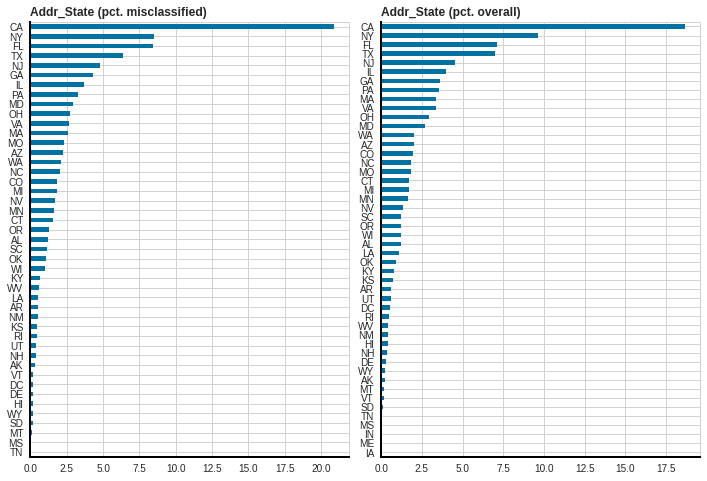

In [67]:
for col, wspace, fig_size in zip(
    ["home_ownership", "purpose", "emp_length", "term", "addr_state"],
    [0.25, 0.4, 0.1, 0.25, 0.1],
    [(12, 4), (12, 4), (12, 4), (12, 4), (12, 8)],
):
    plot_grouped_bar_chart(df_tp, col, "misclassified", wspace, fig_size=fig_size)

**Observations**
1. Of the five states representing nearly half of the data, CA, FL and NJ have a relatively higher number of misclassifications (LHS) than expected based on the percent of overall loans (RHS) attributed to these two states. By comparison, TX and NY have a relatively smaller percent than expected. These percent differences are less than 5%.
2. In terms of the `Employment Length` and `Purpose` columns of the data, the incorrect model predictions follow the frequency of the data - more commonly occurring categories in each of these columns are also more frequently misclassified.
3. The model has approx. the same difficulty (LHS plot) in predicting the outcome for home owners who pay Rent or take a Mortgage to what is observed from the data (RHS plot).
4. For the Term column of the data
   - although nearly 75% of the loans (RHS plot) required 36 monthly payments, the model found here has nearly the same difficulty (LHS plot) predicting loans requiring 36 or 60 monthly payments. The model has trouble with predicting infrequently occurring term loans (60 months) than those that occur more commonly (36 months)
   - this is likely an artifact of the ML pipeline rather than of the data itself
     - since the feature selection step of the pipeline based on the correlation coefficient drops the 60 month encoded column (see the SHAP section) and so all these rows appear as though they have a term of 36 months. This leads to misclassification.
5. The numerical features show the same distribution in the mis-classified and true data.

### Feature Contributions to the unseen mis-classified observations

This section will show how the ML features contribute to the overall prediction. The focus will be on the mis-classified observations from the unseen data and will use a decision plot based on the SHAP values, which shows how ML models reach their final predictions. This will allow a visualization of individual predictions by ML feature.

1. [Decision Plot basics](https://shap.readthedocs.io/en/latest/example_notebooks/plots/decision_plot.html#Basic-decision-plot-features)
2. [Cutoff and SHAP decision plot](https://shap.readthedocs.io/en/latest/example_notebooks/plots/decision_plot.html#Compare-and-contrast-predictions-for-several-models)
   - see
     > If probability 0.5 is our cutoff value for this binary classification task, we see that this observation is difficult to classify. However, Model 2 is confident that the individual makes less than \$50K per year. 
3. [Preserve order and scale across plots](https://shap.readthedocs.io/en/latest/example_notebooks/plots/decision_plot.html#Preserving-order-and-scale-between-plots)
3. [Change SHAP base value](https://shap.readthedocs.io/en/latest/example_notebooks/plots/decision_plot.html#Changing-the-SHAP-base-value)

First, hard predictions are generated on the unseen data using the best discrimination threshold and then a user-specified base value will be computed, using this threshold, for use in the plots in this section

In [185]:
y_pred_test_series = pd.Series(
    (y_probs_test >= best_t).astype("int"), index=X_test.index, name="predicted"
)

In [185]:
p = best_t  # Probability best_
new_base_value = np.log(p / (1 - p))  # the logit function

#### Mis-Classifications - first 5 occurrences only

First, all mis-classifications are shown

In [ ]:
def plot_decision_plot(X, idx_locs, explainer, new_base_value=np.log(0.5 / (1 - 0.5)), n=5):
    features = X.iloc[idx_ilocs[0:n]]
    features_display = X.iloc[features.index]
    shap_values = explainer.shap_values(features)
    r = shap.decision_plot(
        explainer.expected_value,
        explainer.shap_values(features),
        features_display,
        link="logit",
        new_base_value=new_base_value,
        feature_display_range=slice(-1, -X.shape[1], -1),
        highlight=0,
        return_objects=True,
    )

In [ ]:
# %%time
# mismatched = (y_pred_test_series != y_test).reset_index(drop=True)
# mismatched_idx_ilocs = mismatched.loc[mismatched].index.tolist()
# plot_decision_plot(X_test_trans, mismatched_idx_ilocs, explainer, new_base_value)

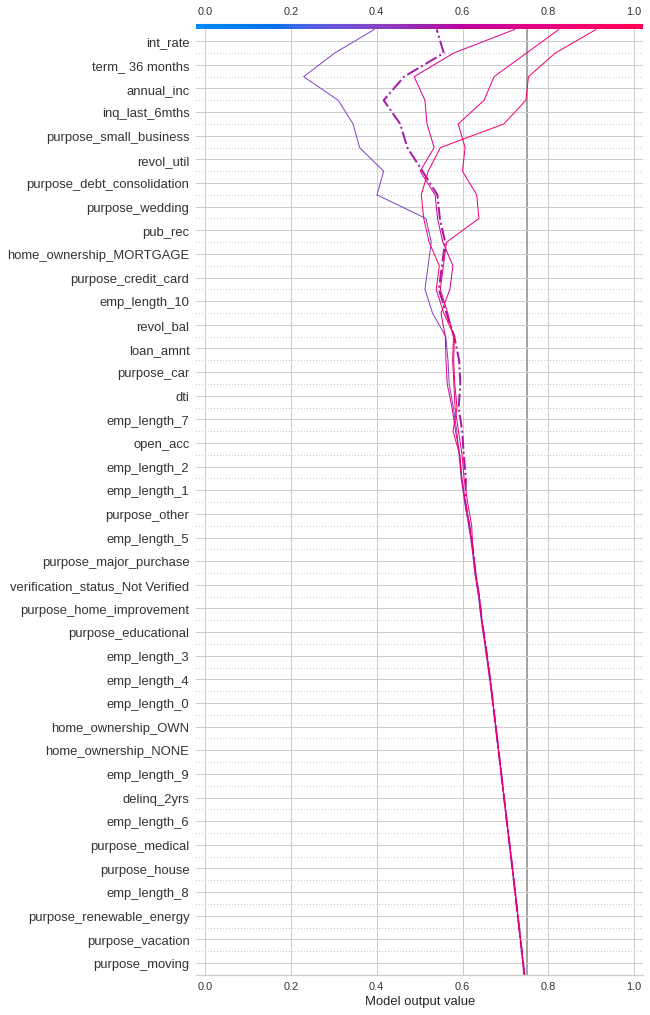

In [186]:
mismatched = (y_pred_test_series != y_test).reset_index(drop=True)
mismatched_idx_ilocs = mismatched.loc[mismatched].index.tolist()
features = X_test_trans.iloc[mismatched_idx_ilocs[0:5]]
features_display = X_test_trans.iloc[features.index]
shap_values = explainer.shap_values(features)
r = shap.decision_plot(
    explainer.expected_value,
    explainer.shap_values(features),
    features_display,
    link="logit",
    new_base_value=new_base_value,
    feature_display_range=slice(-1, -X_test_trans.shape[1], -1),
    highlight=0,
    return_objects=True,
)

**Notes**
1. Each observation’s prediction is shown as a separate line on this plot. The color of each line is determined as follows: at the top of the plot, each line intersects the horizontal-axis at its predicted value - this is greater than 0.75 for defaulted loans (minority class) and less than 0.75 for loans paid off on-time (majority class) and this value determines the color of the bar on top of the plot.
2. The usefulness of the custom base SHAP value is seen in this plot. It allows the predictions to converge at the cutoff value (at the bottom of the plot). Then, moving up the plot, for a single line (i.e. for a single observation), the base value is shifted with no affect on the predicted values.
3. Upon moving up the plot for a single line, the SHAP value for each ML feature is added to the base value. The sum of such changes for all features results in the final prediction output of the model - here, this final output is either greater or less than the best discrimination threshold found earlier. In this way, a decision plot shows the contribution of each ML feature to this final prediction for the specific observation (line).
4. In each plot in this section, for clarity, only the first five occurrences are shown and (arbitrarily) the first of these is hilighted as a dashed line.

**Observations**
1. There appear to be two groupings in the five graphed observations near the top of these plots - one shown in red and the other in purple. This could be due to there being two types of mis-classifications - incorrectly predicting that a loan will default or incorrectly predicting that a loan will be paid off on-time. However, it is difficult to be certain about attributing patterns about feature contributions to either type of loan outcome since both types of mis-classifications are mixed in together in the data used to generate this plot.

#### Correct Classifications - first 5 occurrences only

Next, all correct classifications are shown

In [ ]:
# %%time
# matched = (y_pred_test_series == y_test).reset_index(drop=True)
# matched_idx_ilocs = matched.loc[matched].index.tolist()
# plot_decision_plot(X_test_trans, matched_idx_ilocs, explainer, new_base_value)

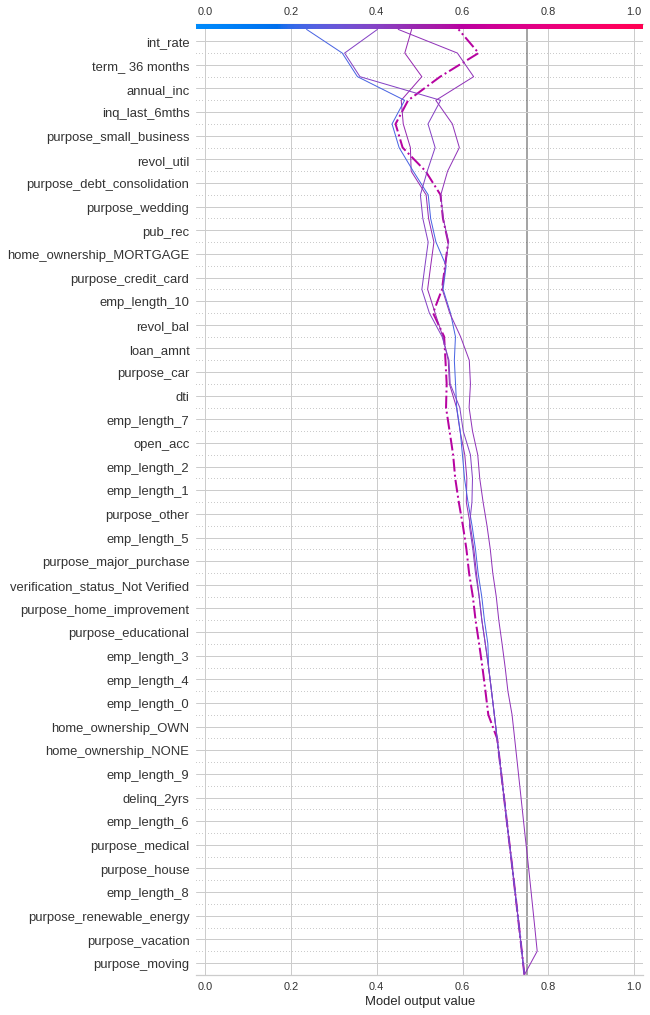

In [187]:
matched = (y_pred_test_series == y_test).reset_index(drop=True)
matched_idx_ilocs = matched.loc[matched].index.tolist()
features = X_test_trans.iloc[matched_idx_ilocs[0:5]]
features_display = X_test_trans.iloc[features.index]
shap_values = explainer.shap_values(features)
shap.decision_plot(
    explainer.expected_value,
    explainer.shap_values(features),
    features_display,
    link="logit",
    new_base_value=new_base_value,
    feature_display_range=slice(-1, -X_test_trans.shape[1], -1),
    highlight=0,
    feature_order=r.feature_idx,
    xlim=r.xlim,
)

**Observations**
1. Again, there are two types of correct classifications possible but, as before, both types are mixed in together in the data used to generate this plot. There do not appear to be two groupings in observations visible in this plot.

In an attempt to focus on possible individual groupings in observations, based on prediction and outcome, the next sections will separately show the
- mis-classifications of defaulted loans (which can be the most costly to an investor)
- two types of correctly predictions
  - correctly predicting defaulted loans
  - correctly predicting loans paid off on-time

#### Mis-Classifications of defaulted loans (actual=`default`, pred=on-time) - first 5 only

Next, only the mis-classifications where the loan results in a default but is not predicted to be so, are shown

In [ ]:
df_tps = pd.concat([y_pred_test_series, y_test], axis=1).reset_index(drop=True)
df_tps_default_wrong = df_tps[(df_tps["is_default"] == 1) & (df_tps[0] == 0)]
display(df_tps_default_wrong.head())

In [ ]:
# %%time
# mismatched_true_default_idx_ilocs = df_tps_default_wrong.index.tolist()
# plot_decision_plot(X_test_trans, mismatched_true_default_idx_ilocs, explainer, new_base_value)

,0,is_default
0,0,1
1,0,1
7,0,1
23,0,1
25,0,1


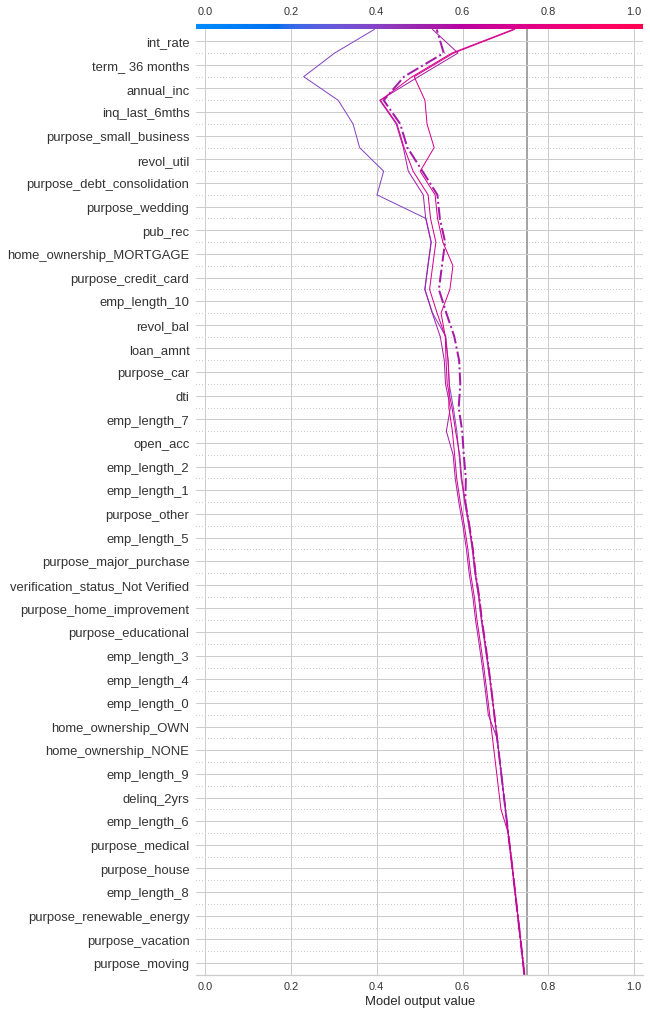

In [210]:
mismatched_true_default_idx_ilocs = df_tps_default_wrong.index.tolist()
features = X_test_trans.iloc[mismatched_true_default_idx_ilocs[0:5]]
features_display = X_test_trans.iloc[features.index]
shap_values = explainer.shap_values(features)
shap.decision_plot(
    explainer.expected_value,
    explainer.shap_values(features),
    features_display,
    link="logit",
    new_base_value=new_base_value,
    feature_display_range=slice(-1, -X_test_trans.shape[1], -1),
    highlight=0,
    feature_order=r.feature_idx,
    xlim=r.xlim,
)

#### Correct Classifications of defaulted loans (actual=pred=`default`) - first 5 only

Below, the correct classifications where the loan results in a default (and is predicted to be so), are shown - this is to facilitate a comparison of factors contributing to predictions for defaulted loans

In [ ]:
df_tps = pd.concat([y_pred_test_series, y_test], axis=1).reset_index(drop=True)
df_tps_default_correct = df_tps[(df_tps["is_default"] == 1) & (df_tps[0] == 1)]
display(df_tps_default_correct.head())

In [ ]:
# %%time
# matched_true_default_idx_ilocs = df_tps_default_correct.index.tolist()
# plot_decision_plot(X_test_trans, matched_true_default_idx_ilocs, explainer, new_base_value)

,0,is_default
78,1,1
101,1,1
216,1,1
268,1,1
318,1,1


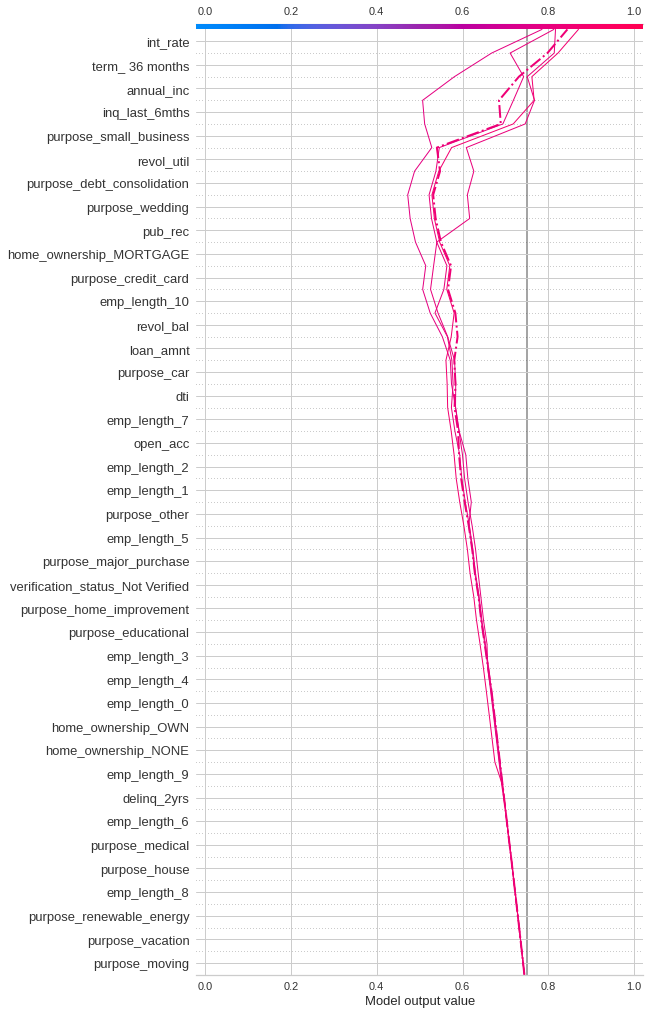

In [208]:
# matched = (y_pred_test_series == y_test).reset_index(drop=True)
matched_true_default_idx_ilocs = df_tps_default_correct.index.tolist()
features = X_test_trans.iloc[matched_true_default_idx_ilocs[0:5]]
features_display = X_test_trans.iloc[features.index]
shap_values = explainer.shap_values(features)
shap.decision_plot(
    explainer.expected_value,
    explainer.shap_values(features),
    features_display,
    link="logit",
    new_base_value=new_base_value,
    feature_display_range=slice(-1, -X_test_trans.shape[1], -1),
    highlight=0,
    feature_order=r.feature_idx,
    xlim=r.xlim,
)

#### Correct Classifications of paid off loans (actual=pred=on-time) - first 5 only

Finally, correctly predicted loans that are paid off on-time are shown

In [ ]:
df_tps = pd.concat([y_pred_test_series, y_test], axis=1).reset_index(drop=True)
df_tps_paid_correct = df_tps[(df_tps["is_default"] == 0) & (df_tps[0] == 0)]
display(df_tps_paid_correct.head())

In [ ]:
# %%time
# matched_true_paid_idx_ilocs = df_tps_paid_correct.index.tolist()
# plot_decision_plot(X_test_trans, matched_true_paid_idx_ilocs, explainer, new_base_value)

,0,is_default
2,0,0
3,0,0
5,0,0
6,0,0
8,0,0


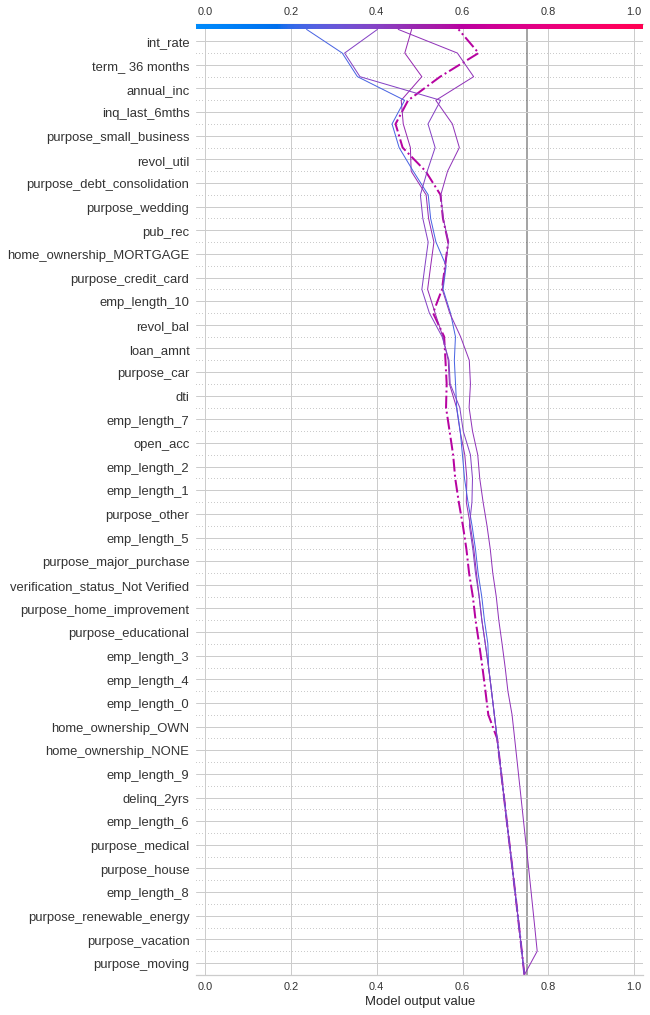

In [209]:
# matched = (y_pred_test_series == y_test).reset_index(drop=True)
matched_true_paid_idx_ilocs = df_tps_paid_correct.index.tolist()
features = X_test_trans.iloc[matched_true_paid_idx_ilocs[0:5]]
features_display = X_test_trans.iloc[features.index]
shap_values = explainer.shap_values(features)
shap.decision_plot(
    explainer.expected_value,
    explainer.shap_values(features),
    features_display,
    link="logit",
    new_base_value=new_base_value,
    feature_display_range=slice(-1, -X_test_trans.shape[1], -1),
    highlight=0,
    feature_order=r.feature_idx,
    xlim=r.xlim,
)

#### Observations

1. Considering the contribution of interest rate, loan term (36 months) and annual income of the borrower to whether a loan will be predicted to default
   - for both correctly and incorrectly classified default loan outcomes, these three features contributions to the overall prediction are generally similar (see second and third last plots above)
2. `inq_last_6mths`, `purpose_small_business` and `revol_util` make the distinct contributions to loans that are correctly or incorrectly predicted to result in a default
   - these were among the most important features identified earlier using the three different proxies for feature importance
   - they don't make much of a contribution either loans that are correctly predicted to be paid off on-time and also to defaulted loans that are misclassified as being paid off on-time (see last and third last plots above)
   - they make a strong contribution to correctly predicted defaulted loans (second last plot above)
     - visually, they show the highest probabilty of driving the prediction in the direction of a default and this is distinct from their behaviour/trend in the other two plots (last and third last plots)
   - if a better explanation of the outcome of defaulted loans is required, then contrasting these factors for correctly and incorrectly predicted defaulted loans are worth examining

## Conclusion

Quantifying the output of a predictive classification ML model allows for an customization of ML to the business user. In the case of a conservative investor looking to determine whether or not to fund loans on the Lending Club platform, such an approach allows for estimating the extent of a loss that could result from relying on an ML model-based approach to making such decisions.

This version of ML modeling builds on preceding steps of data cleaning ([1](https://nbviewer.jupyter.org/github/edesz/predict-loan-defaults/blob/master/1_feature_reduction.ipynb), [2](https://nbviewer.jupyter.org/github/edesz/predict-loan-defaults/blob/master/2_feature_processing.ipynb)) and [exploratory data analysis](https://nbviewer.jupyter.org/github/edesz/predict-loan-defaults/blob/master/3_exploratory_data_analysis.ipynb), in order to understand the data and prepare it (eg. filtering the data) for quantitative analysis.

The ML modeling workflow shows the following
- the use of built-in or manually specified class weights to account for the significantly larger number of defaulted loans compared to those that were paid on time were used in the best-performing ML models
- optimization of the ML model's [discrimination threshold](https://chemicalstatistician.wordpress.com/tag/discrimination-threshold/) based on a case-specific cost function allowed for a better approximation of translating the error in the model's predictions to a dollar cost incurred by the investor (business user)
  - using the confusion matrix produced by the ML model's predictions, this cost function
    - takes into acount the approximate dollar value associated with outcome-based scenarios such predicting a loan will be paid back on time when it actually results in a default
    - uses the returns (total loan income) to estimate the error of the ML model's predictions and translate hard predictions of the loan outcome into an error metric reflecting the difference in loan income earned by following the ML model predictions and the true outcome of the loan
- across three approaches for estimating the importance of factors in the data to the ML model's predictions on unseen data, the purpose for requesting the loan was found to be the most important factor in the predictions made by the ML model, with `inq_last_6mths` (number of inquiries into the borrower's credit file), `dti` (the borrower's debt-to-income ratio) and `revol_bal` (unpaid fraction of a borrower's credit card spending) next in line

## Looking Forward

Further iterations of this project should focus on the following
1. Actual training data and monetary cost function assignments (currently taken from the confusion matrix and total loan income calculations) could be more complex
   - including higher interest rate due to missed payments that do not result in default
     - affects calculation of total loan income
   - some borrowers who are predicted to pay off the loan on time will default
     - including a probability of default, despite being predicted not to, in the cost (returns) function , used for threshold tuning, could provide a better ROI on an investor's funding rounds
2. Aspects of the ML workflow
   - Feature Engineering
     - extracting machine learning features from the raw Lending Club data
     - unfortunately, dates are not provided and so the evolution of borrower behaviour is not known
       - if housing costs are increasing but the borrower's salary stays the same, then this could lead to more defaults
       - a customer profile should incorporate behaviour trends
   - Feature Selection
     - consider a less stringent threshold (currently 50%) for dropping features with missing data
       - this could possibly re-introduce some features into the dataset that hopefully add predictive power to the models tried
     - different approach to removal of correlated features (currently a simple rule is used drop highly correlated features) in the dataset before the ML process begins
   - Interpretability
     - additional techniques for interpreting the importance of features to the ML model's predictions on unseen data, especially around the `delinq_2yrs`, `emp_length` and `open_acc` features which seem to be the most sensitive to the method used to explore feature importances
   - Features attributed to ML model's mis-classifications
     - based on incorrect model predictions, further exploration (incl. outlier removal) of the loan term column from the data is warranted